In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os, random
import numpy as np
import tensorflow as tf

def set_seed(seed=42):
    import os, random
    import numpy as np
    import tensorflow as tf

    # Python & Numpy
    random.seed(seed)
    np.random.seed(seed)

    # TF & GPU
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

    # evviornment seetings
    os.environ["PYTHONHASHSEED"] = str(seed)
    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

    print(f"[INFO] Seed set to {seed}, deterministic ops enabled")
set_seed(42)
print("GPUs:", tf.config.list_physical_devices('GPU'))

[INFO] Seed set to 42, deterministic ops enabled
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import json
import pandas as pd

In [4]:
data_dir = '/content/drive/MyDrive/UMLTA3'

X_ai = np.load(os.path.join(data_dir, "train_ai.npy"))
X_human = np.load(os.path.join(data_dir, "train_human.npy"))

df_val = pd.read_json(os.path.join(data_dir, "validation.jsonl"), lines=True)
df_test = pd.read_json(os.path.join(data_dir, "test_features.jsonl"), lines=True)

In [5]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from collections import Counter

def print_class_balance(y, name="set"):
    counter = Counter(y)
    total = len(y)
    print(f"{name} size: {total}")
    for cls, cnt in sorted(counter.items()):
        ratio = cnt / total
        print(f"  class {cls}: {cnt} ({ratio:.3f})")

y_ai = np.ones(len(X_ai), dtype=np.int32)
y_human = np.zeros(len(X_human), dtype=np.int32)

X_all = np.concatenate([X_ai, X_human], axis=0)
y_all = np.concatenate([y_ai, y_human], axis=0)

X_all, y_all = shuffle(X_all, y_all, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all,
    test_size=0.3,          # 30% for evalidation
    random_state=42,
    stratify=y_all          # label balance
)

print("Train Shape:", X_train.shape, y_train.shape)
print("Val Shape:", X_val.shape, y_val.shape)
print_class_balance(y_train, "Train")
print_class_balance(y_val, "Val")

Train Shape: (11425, 100, 768) (11425,)
Val Shape: (4897, 100, 768) (4897,)
Train size: 11425
  class 0: 5712 (0.500)
  class 1: 5713 (0.500)
Val size: 4897
  class 0: 2449 (0.500)
  class 1: 2448 (0.500)


In [6]:
X_val_list, y_val_list, val_id_list = [], [], []
for row in df_val.itertuples():
    arr = np.array(row.features, dtype=np.float32)   # (N_i,100,768)
    for sub in arr:  # sub is slice for each id: (100,768)
        X_val_list.append(sub)
        y_val_list.append(row.label)
        val_id_list.append(row.id)

X_val_external = np.stack(X_val_list)
y_val_external = np.array(y_val_list)
val_ids = np.array(val_id_list)

print(X_val_external.shape, y_val_external.shape, val_ids.shape, len(np.unique(val_ids)))

(220, 100, 768) (220,) (220,) 20


In [7]:
X_test_list, test_id_list = [], []
for row in df_test.itertuples():
    arr = np.array(row.features, dtype=np.float32)
    for sub in arr:
        X_test_list.append(sub)
        test_id_list.append(row.id)

X_test = np.stack(X_test_list)
test_ids = np.array(test_id_list)

print(X_test.shape, test_ids.shape, len(np.unique(test_ids)))

(1686, 100, 768) (1686,) 180


Prepare for evaluate function

In [8]:
import matplotlib.pyplot as plt

def plot_history(history):

    hist = history.history
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # --- Loss ---
    axes[0].plot(hist["loss"], label="train")
    if "val_loss" in hist:
        axes[0].plot(hist["val_loss"], label="val")
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # --- Accuracy ---
    if "accuracy" in hist:
        axes[1].plot(hist["accuracy"], label="train")
    if "val_accuracy" in hist:
        axes[1].plot(hist["val_accuracy"], label="val")
    axes[1].set_title("Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()

    # --- ROC AUC ---
    if "roc_auc" in hist:
        axes[2].plot(hist["roc_auc"], label="train")
    if "val_roc_auc" in hist:
        axes[2].plot(hist["val_roc_auc"], label="val")
    axes[2].set_title("ROC AUC")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("AUC")
    axes[2].legend()

    plt.tight_layout()
    plt.show()

In [9]:
from sklearn.metrics import roc_auc_score, classification_report

def evaluate_model(model, X, y, ids=None, agg="mean", threshold=0.5, digits=3):

    # ---- Sequence Level ----
    probs = model.predict(X).ravel()
    auc_sample = roc_auc_score(y, probs)
    preds = (probs > threshold).astype(int)

    print("Sample-level AUROC:", round(auc_sample, 4))
    print("Classification Report (sample-level):")
    print(classification_report(y, preds, digits=digits))

    auc_doc = None
    if ids is not None and agg is not None:
        doc_probs = {}
        doc_labels = {}
        for p, yy, i in zip(probs, y, ids):
            doc_probs.setdefault(i, []).append(p)
            doc_labels[i] = yy

        # merge
        if agg == "mean":
            doc_probs = {i: np.mean(v) for i, v in doc_probs.items()}
        elif agg == "max":
            doc_probs = {i: np.max(v) for i, v in doc_probs.items()}
        elif agg == "vote":
            doc_probs = {i: (np.mean(v) > 0.5).astype(float) for i, v in doc_probs.items()}
        else:
            raise ValueError("agg must be 'mean' | 'max' | 'vote'")

        doc_probs = np.array(list(doc_probs.values()))
        doc_labels = np.array(list(doc_labels.values()))
        auc_doc = roc_auc_score(doc_labels, doc_probs)

        print(f"Doc-level AUROC ({agg}):", round(auc_doc, 4))

According to the task description, we will evaluate two candidate models — BiGRU and MLP — to determine which one should proceed to further tuning. The aim at this stage is to use models with fewer parameters in order to observe their convergence behaviour.

Test 1: MLP embedding

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers as reg

def build_mlp(
    input_shape=(100, 768),
    hidden1=128,            # first hidden layer
    hidden2=64,             # second hidden layer
    dropout=0.4,
    l2_reg=1e-4,
    learning_rate=1e-4,
    label_smoothing=0.01,
    clipnorm=1.0,
    activation="relu",
    use_batchnorm=False,
    optimizer="adam"
):
    """Factory function for 2-layer MLP (mask-aware pooling + 2 Dense layers)."""

    # ---- Input & mask ----
    inp  = layers.Input(shape=input_shape, dtype="float32")
    mask = layers.Lambda(lambda t: tf.reduce_any(tf.not_equal(t, 0.0), axis=-1))(inp)

    # ---- Mask-aware mean pooling -> (B, D) ----
    pooled = layers.Lambda(
        lambda a: tf.reduce_sum(a[0] * tf.cast(a[1][..., None], tf.float32), axis=1) /
                  tf.clip_by_value(tf.reduce_sum(tf.cast(a[1][..., None], tf.float32), axis=1), 1., 1e9)
    )([inp, mask])

    # ---- MLP head ----
    x = pooled
    if use_batchnorm:
        x = layers.BatchNormalization()(x)
    # First Dense
    x = layers.Dense(hidden1, activation=activation,
                     kernel_regularizer=reg.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)
    # Second Dense
    x = layers.Dense(hidden2, activation=activation,
                     kernel_regularizer=reg.l2(l2_reg))(x)
    x = layers.Dropout(dropout)(x)

    # Output
    out = layers.Dense(1, activation="sigmoid", dtype="float32")(x)

    model = models.Model(inp, out)

    # ---- Optimizer setup ----
    if isinstance(optimizer, str):
        if optimizer.lower() == "adam":
            opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=clipnorm)
        elif optimizer.lower() == "adamw":
            opt = tf.keras.optimizers.AdamW(learning_rate=learning_rate, clipnorm=clipnorm)
        elif optimizer.lower() == "sgd":
            opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True, clipnorm=clipnorm)
        elif optimizer.lower() == "rmsprop":
            opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, clipnorm=clipnorm)
        else:
            raise ValueError(f"Unsupported optimizer: {optimizer}")
    else:
        opt = optimizer

    # ---- Compile model ----
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=label_smoothing)
    model.compile(
        optimizer=opt,
        loss=loss,
        metrics=["accuracy", tf.keras.metrics.AUC(curve="ROC", name="roc_auc")],
    )
    return model

In [14]:
set_seed(42)

mlp_baseline = build_mlp(
    input_shape=(100, 768),   # shape of each sample
    hidden1=128,              # first hidden layer size
    hidden2=64,               # second hidden layer size
    dropout=0.4,              # dropout rate
    l2_reg=1e-4,              # L2 regularization
    learning_rate=1e-4,       # learning rate
    label_smoothing=0.01,     # label smoothing
    clipnorm=1.0,             # gradient clipping
    activation="relu",        # activation function
    use_batchnorm=False       # batch norm option
)

mlp_baseline.summary()

[INFO] Seed set to 42, deterministic ops enabled


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100, 768)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 100)       │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 768)       │          0 │ input_layer_1[0]… │
│                     │                   │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     98,432 │ lambda_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 106,753 (417.00 KB)

 Trainable params: 106,753 (417.00 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
history1 = mlp_baseline.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    verbose=1
)

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.6381 - loss: 0.6876 - roc_auc: 0.6805 - val_accuracy: 0.7337 - val_loss: 0.5695 - val_roc_auc: 0.8099
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7262 - loss: 0.5729 - roc_auc: 0.8027 - val_accuracy: 0.7625 - val_loss: 0.5315 - val_roc_auc: 0.8424
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.7665 - loss: 0.5251 - roc_auc: 0.8439 - val_accuracy: 0.7987 - val_loss: 0.4775 - val_roc_auc: 0.8810
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8007 - loss: 0.4794 - roc_auc: 0.8776 - val_accuracy: 0.8205 - val_loss: 0.4387 - val_roc_auc: 0.9019
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8180 - loss: 0.4485 - roc_auc: 0.8951 - val_accuracy: 0.8381 - val_loss: 0.4113 - val_roc_auc: 0.9142
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8370 - loss: 0.4138 - roc_auc: 0.9134 - val_accuracy: 0.8464 - val_loss: 0.3901 - val_ro

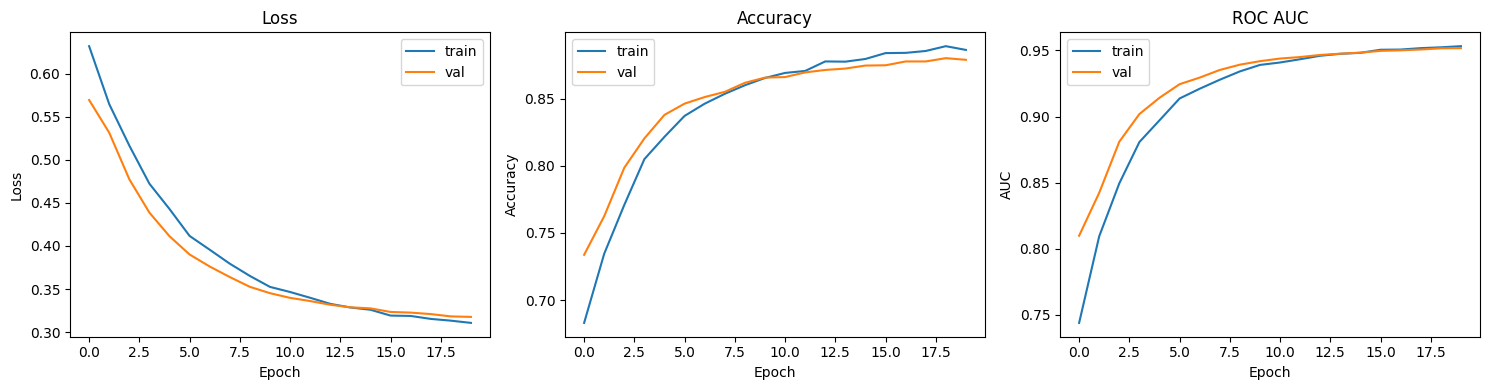

In [16]:
plot_history(history1)

In [17]:
evaluate_model(model=mlp_baseline, X=X_val_external, y=y_val_external, ids=val_ids, agg="mean")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Sample-level AUROC: 0.7705
Classification Report (sample-level):
              precision    recall  f1-score   support

           0      0.690     0.806     0.743       124
           1      0.680     0.531     0.596        96

    accuracy                          0.686       220
   macro avg      0.685     0.669     0.670       220
weighted avg      0.685     0.686     0.679       220

Doc-level AUROC (mean): 0.92


Test 2: BiGRU + Multi-Head Attention

In [18]:
def build_bigru_light(
    input_shape=(100, 768),
    gru_units=64,
    gru_dropout=0.2,
    mha_heads=4,
    mha_keydim=32,
    mha_dropout=0.1,
    dense_units=128,
    dense_dropout=0.4,
    l2_reg=1e-4,
    learning_rate=1e-4,
    label_smoothing=0.01,
    clipnorm=1.0,
    optimizer="adam"   # <--- NEW: optimizer choice
):
    """Factory function for BiGRU+Attention model with flexible optimizer."""

    # ---- input & mask ----
    inp  = layers.Input(shape=input_shape, dtype="float32")
    mask = layers.Lambda(lambda t: tf.reduce_any(tf.not_equal(t, 0.0), axis=-1))(inp)

    # ---- BiGRU ----
    x = layers.Bidirectional(
            layers.GRU(gru_units, return_sequences=True,
                       dropout=gru_dropout, recurrent_dropout=0.0)
        )(inp, mask=mask)

    # ---- Multi-Head Attention ----
    attn = layers.MultiHeadAttention(
        num_heads=mha_heads, key_dim=mha_keydim, dropout=mha_dropout
    )(x, x, attention_mask=mask[:, None, None, :])

    # Residual + Norm + Dropout
    x = layers.Add()([x, attn])
    x = layers.LayerNormalization()(x)
    x = layers.SpatialDropout1D(gru_dropout)(x)

    # ---- Mask-aware mean pooling ----
    pooled = layers.Lambda(
        lambda args: tf.reduce_sum(args[0] * tf.cast(args[1][..., None], tf.float32), axis=1) /
                     tf.clip_by_value(tf.reduce_sum(tf.cast(args[1][..., None], tf.float32), axis=1), 1., 1e9)
    )([x, mask])

    # ---- Dense head ----
    h = layers.Dense(dense_units, activation="relu",
                     kernel_regularizer=reg.l2(l2_reg))(pooled)
    h = layers.Dropout(dense_dropout)(h)
    out = layers.Dense(1, activation="sigmoid", dtype="float32")(h)

    model = models.Model(inp, out)

    # ---- Optimizer selection ----
    if optimizer.lower() == "adam":
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=clipnorm)
    elif optimizer.lower() == "adamw":
        opt = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=1e-5, clipnorm=clipnorm)
    elif optimizer.lower() == "rmsprop":
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, clipnorm=clipnorm)
    elif optimizer.lower() == "sgd":
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, clipnorm=clipnorm)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer}")

    # ---- Compile ----
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=label_smoothing)
    model.compile(
        optimizer=opt,
        loss=loss,
        metrics=["accuracy", tf.keras.metrics.AUC(curve="ROC", name="roc_auc")]
    )
    return model

In [21]:
set_seed(42)

bigru_light = build_bigru_light(
    input_shape=(100, 768),
    gru_units=16,
    gru_dropout=0.2,
    mha_heads=4,
    mha_keydim=32,
    mha_dropout=0.1,
    dense_units=32,
    dense_dropout=0.4,
    l2_reg=1e-4,
    learning_rate=1e-4,
    label_smoothing=0.01,
    clipnorm=1.0,
    optimizer="adam"   # or "adamw", "rmsprop", "sgd"
)

bigru_light.summary()

[INFO] Seed set to 42, deterministic ops enabled


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 100, 768)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_8 (Lambda)   │ (None, 100)       │          0 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 100, 32)   │     75,456 │ input_layer_4[0]… │
│ (Bidirectional)     │                   │            │ lambda_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 1, 1, 100) │          0 │ lambda_8[0][0]    │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 32)   │     16,800 │ bidirectional_2[… │
│ (MultiHeadAttentio… │                   │            │ bidirectional_2[… │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 100, 32)   │          0 │ bidirectional_2[… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 32)   │         64 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_2 │ (None, 100, 32)   │          0 │ layer_normalizat… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_9 (Lambda)   │ (None, 32)        │          0 │ spatial_dropout1… │
│                     │                   │            │ lambda_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 32)        │      1,056 │ lambda_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 32)        │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1)         │         33 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 93,409 (364.88 KB)

 Trainable params: 93,409 (364.88 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history2 = bigru_light.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    verbose=1
)

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.6038 - loss: 0.6753 - roc_auc: 0.6451 - val_accuracy: 0.7307 - val_loss: 0.5454 - val_roc_auc: 0.8057
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7101 - loss: 0.5749 - roc_auc: 0.7782 - val_accuracy: 0.7517 - val_loss: 0.5217 - val_roc_auc: 0.8268
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7421 - loss: 0.5463 - roc_auc: 0.8064 - val_accuracy: 0.7876 - val_loss: 0.4767 - val_roc_auc: 0.8631
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7552 - loss: 0.5146 - roc_auc: 0.8313 - val_accuracy: 0.8156 - val_loss: 0.4312 - val_roc_auc: 0.8893
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7932 - loss: 0.4612 - roc_auc: 0.8706 - val_accuracy: 0.8246 - val_loss: 0.4049 - val_roc_auc: 0.9044
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.8120 - loss: 0.4406 - roc_auc: 0.8834 - val_accuracy: 0.8377 - val_loss: 0.3868 - val_r

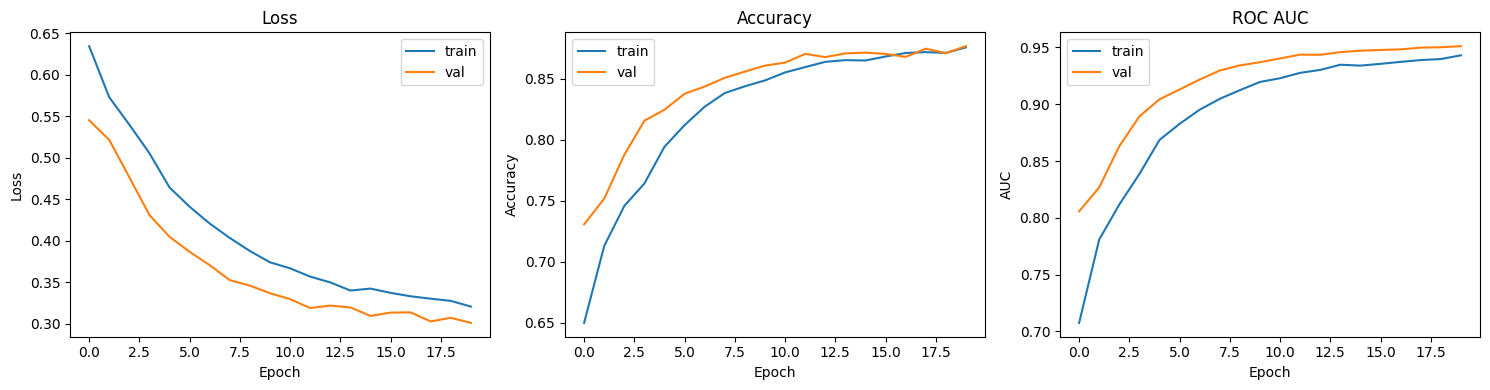

In [23]:
plot_history(history2)

In [24]:
evaluate_model(model=bigru_light, X=X_val_external, y=y_val_external, ids=val_ids, agg="mean")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step
Sample-level AUROC: 0.7741
Classification Report (sample-level):
              precision    recall  f1-score   support

           0      0.705     0.790     0.745       124
           1      0.679     0.573     0.621        96

    accuracy                          0.695       220
   macro avg      0.692     0.682     0.683       220
weighted avg      0.694     0.695     0.691       220

Doc-level AUROC (mean): 0.93


Two candidate models were tested under identical optimization settings: a lightweight MLP baseline (106,753 parameters, 417 KB) and a BiGRU with attention (93,409 parameters, 365 KB).

The MLP converged smoothly with stable training curves. Validation accuracy plateaued at ~87.2% and ROC AUC at ~0.949 by epoch 15, indicating that while the model is efficient and fast to train, its performance ceiling is relatively limited.

The BiGRU, though slightly smaller in parameter count and with less smooth curves, achieved stronger results: validation accuracy of ~87.6% and ROC AUC of ~0.953. Importantly, its validation performance was still improving at epoch 20, suggesting greater capacity and better generalization.

Conclusion: The MLP provides a solid sanity-check baseline, but the BiGRU demonstrates superior performance and more room for further optimization. For subsequent tuning experiments, the BiGRU is the recommended candidate model.

--Update History Plot Codes for Tuning----

In [25]:
def plot_history_dict(hist, title=None):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # --- Loss ---
    axes[0].plot(hist["loss"], label="train")
    if "val_loss" in hist:
        axes[0].plot(hist["val_loss"], label="val")
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # --- Accuracy ---
    if "accuracy" in hist:
        axes[1].plot(hist["accuracy"], label="train")
    if "val_accuracy" in hist:
        axes[1].plot(hist["val_accuracy"], label="val")
    axes[1].set_title("Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()

    # --- ROC AUC ---
    if "roc_auc" in hist:
        axes[2].plot(hist["roc_auc"], label="train")
    if "val_roc_auc" in hist:
        axes[2].plot(hist["val_roc_auc"], label="val")
    axes[2].set_title("ROC AUC")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("AUC")
    axes[2].legend()

    if title:
        fig.suptitle(title, fontsize=14)

    plt.tight_layout()
    plt.show()

--- Optimizer & Learning Rate Tuning ----

From above results, we notice 1e-4 might be a little bit small as the epcho show slowly converence. try check higher learning rate here.

In [26]:
# === Step 2 Optimizer + LR Search ===
search_space1 = [
    ("adam",   1e-4),   # levead this
    ("adam",   3e-4),
    ("adamw",  3e-4),
    ("rmsprop", 3e-4),
    ("sgd",   1e-4),   # bumped up from 2e-4
]

In [27]:
results1 = []
histories1 = {}   # save each combinations' history

In [28]:
for opt_name, lr in search_space1:
    print(f"\n===== Testing {opt_name} (lr={lr}) =====")

    set_seed(42)

    # build model
    model = build_bigru_light(
        input_shape=(100, 768),
        gru_units=16,
        gru_dropout=0.2,
        mha_heads=4,
        mha_keydim=32,
        mha_dropout=0.1,
        dense_units=32,
        dense_dropout=0.4,
        l2_reg=1e-4,
        learning_rate=lr,
        label_smoothing=0.01,
        clipnorm=1.0,
        optimizer=opt_name
    )

    # train with early stopping
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=64,
        verbose=0,
        callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True
        )]
    )

    # evaluate
    val_auc = model.evaluate(X_val, y_val, verbose=0)[2]  # index 2 = roc_auc
    print(f"Validation AUROC: {val_auc:.4f}")

    results1.append((opt_name, lr, val_auc))
    histories1[(opt_name, lr)] = history.history  # save result for loss/metrics


===== Testing adam (lr=0.0001) =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9511

===== Testing adam (lr=0.0003) =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9585

===== Testing adamw (lr=0.0003) =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9585

===== Testing rmsprop (lr=0.0003) =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9505

===== Testing sgd (lr=0.0001) =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.7975


In [29]:
# Sort results by val_roc_auc (descending)
results_sorted1 = sorted(results1, key=lambda x: x[2], reverse=True)

# Print summary
print("\n===== Summary of Optimizer Search =====")
for opt_name, lr, auc in results_sorted1:
    print(f"{opt_name:7s}  lr={lr:<.1e}  ->  val_roc_auc={auc:.4f}")


===== Summary of Optimizer Search =====
adam     lr=3.0e-04  ->  val_roc_auc=0.9585
adamw    lr=3.0e-04  ->  val_roc_auc=0.9585
adam     lr=1.0e-04  ->  val_roc_auc=0.9511
rmsprop  lr=3.0e-04  ->  val_roc_auc=0.9505
sgd      lr=1.0e-04  ->  val_roc_auc=0.7975


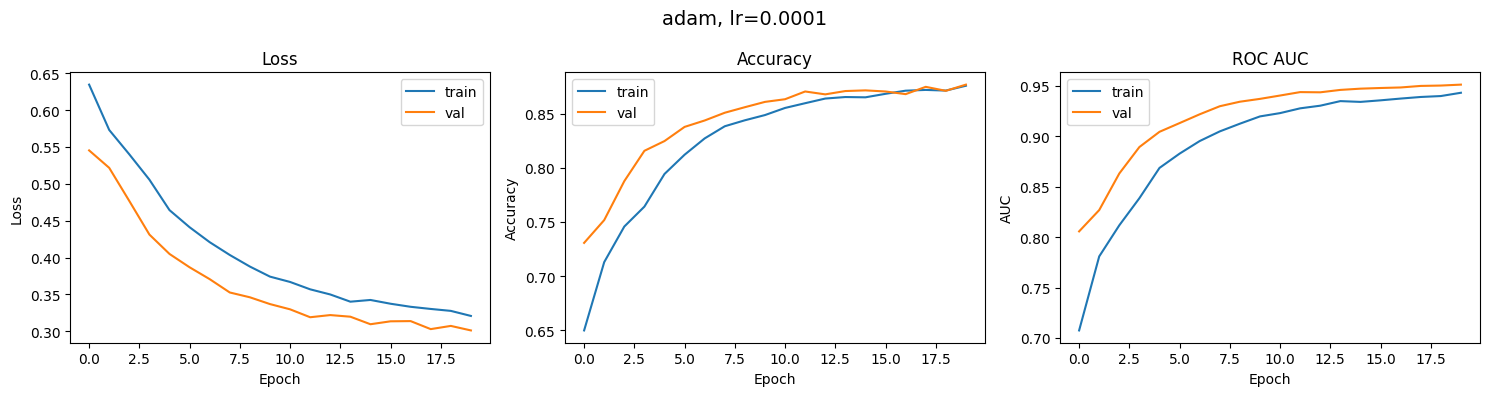

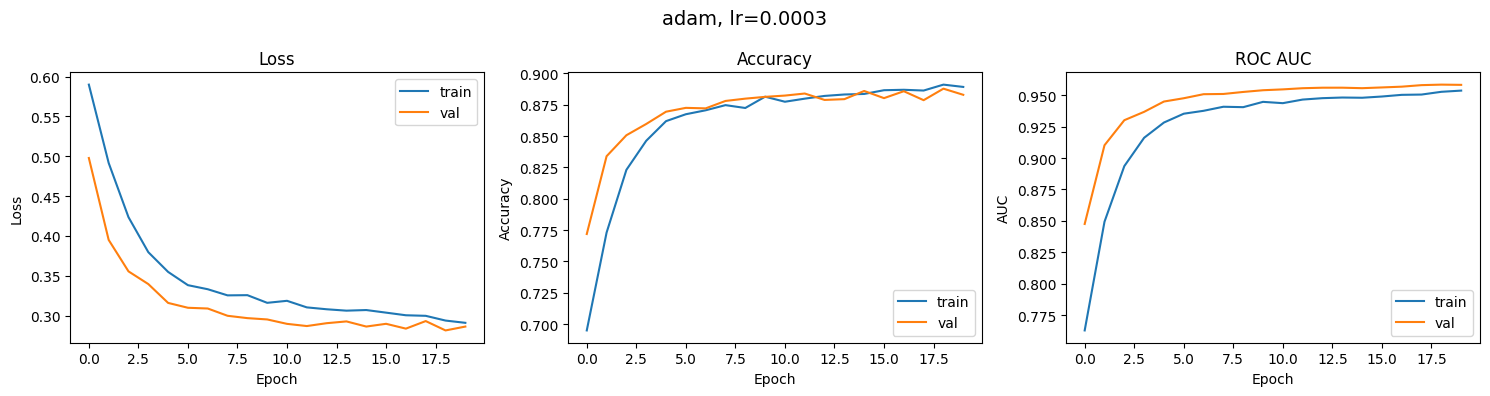

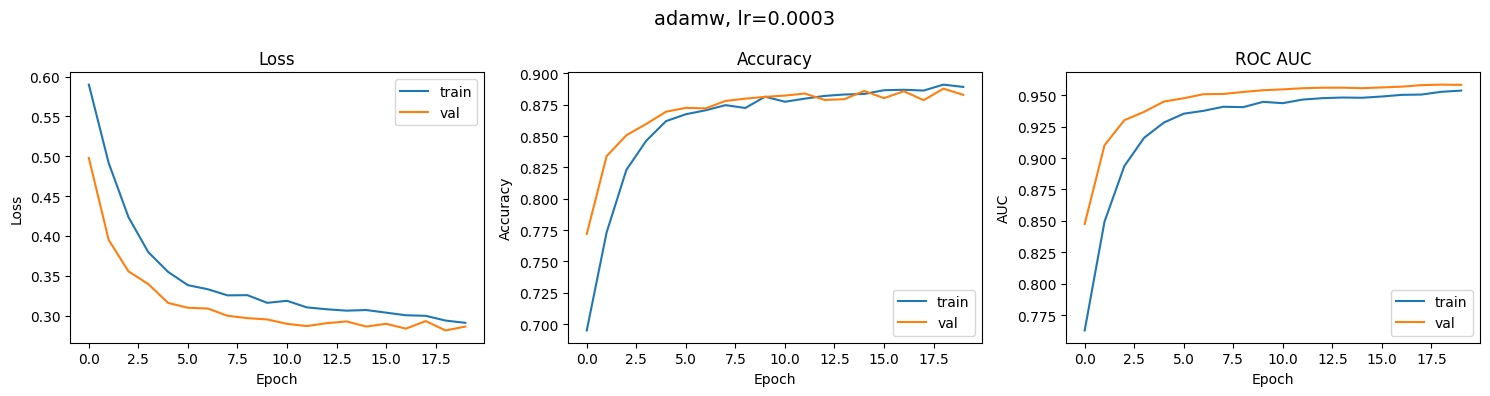

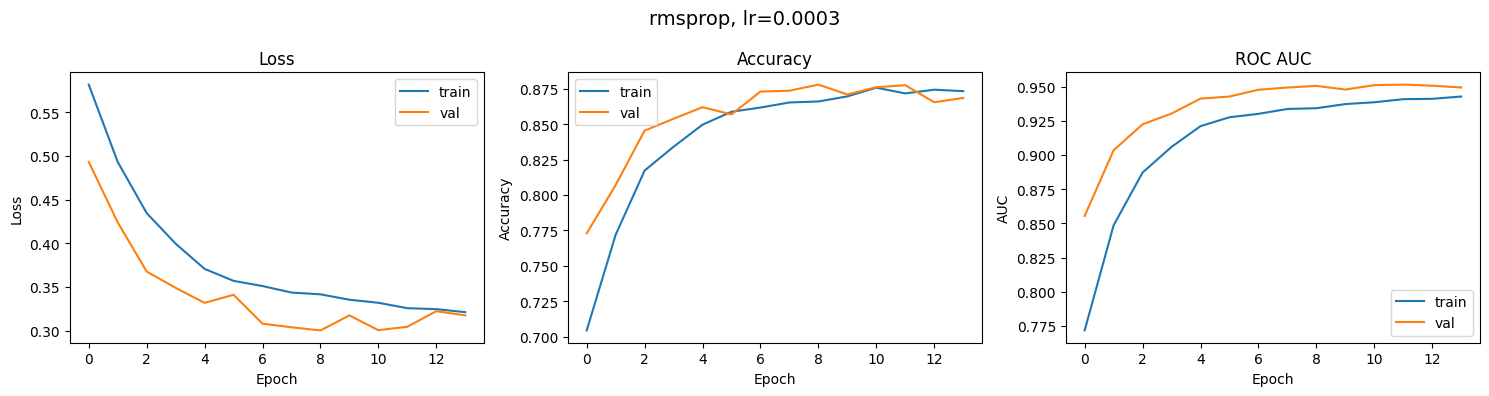

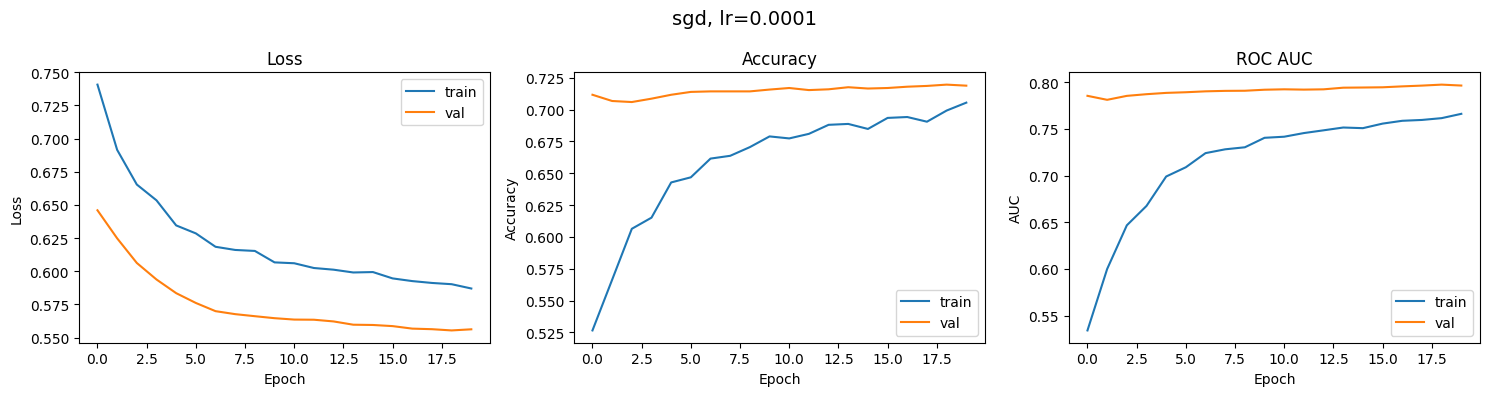

In [30]:
for (opt_name, lr), hist in histories1.items():
    title = f"{opt_name}, lr={lr}"
    plot_history_dict(hist, title=title)

Summary of Optimizer Search:
Among all optimizer–learning rate combinations, Adam (lr=3e-4) and AdamW (lr=3e-4) achieved the highest validation AUC (0.9585). Between the two, Adam showed smoother convergence with fewer fluctuations, making it the more reliable choice. Therefore, Adam with lr=3e-4 was selected as the baseline configuration for subsequent experiments.

In [31]:
best_opt = "adam"
best_lr  = 3e-4

--- Model Capacity (gru_units, dense_units) ----

In [32]:
# === Step 3: Model Capacity Search ===
search_space2 = [
    (16, 32),   # baseline (current best so far)
    (32, 32),   # slightly larger GRU, same dense
    (32, 64),   # larger dense layer
    (64, 64),   # balanced mid-size
    (64, 96),   # larger config
]

In [33]:
results2 = []
histories2 = {}

In [34]:
for gru_units, dense_units in search_space2:
    print(f"\n===== Testing GRU={gru_units}, Dense={dense_units} =====")

    set_seed(42)

    # build model (using best_opt, best_lr)
    model = build_bigru_light(
        input_shape=(100, 768),
        gru_units=gru_units,
        gru_dropout=0.2,
        mha_heads=4,
        mha_keydim=32,
        mha_dropout=0.1,
        dense_units=dense_units,
        dense_dropout=0.4,
        l2_reg=1e-4,
        learning_rate=best_lr,
        label_smoothing=0.01,
        clipnorm=1.0,
        optimizer=best_opt
    )

    # train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=64,
        verbose=0,
        callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True
        )]
    )

    # evaluate
    val_auc = model.evaluate(X_val, y_val, verbose=0)[2]  # index 2 = roc_auc
    print(f"Validation AUROC: {val_auc:.4f}")

    results2.append((gru_units, dense_units, val_auc))
    histories2[(gru_units, dense_units)] = history.history


===== Testing GRU=16, Dense=32 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9585

===== Testing GRU=32, Dense=32 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9588

===== Testing GRU=32, Dense=64 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9596

===== Testing GRU=64, Dense=64 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9603

===== Testing GRU=64, Dense=96 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9608


In [35]:
# === Step 3: Capacity Search Summary ===
results2_sorted = sorted(results2, key=lambda x: x[2], reverse=True)

print("\n===== Summary of Capacity Search =====")
for gru_units, dense_units, auc in results2_sorted:
    print(f"GRU={gru_units:3d}, Dense={dense_units:3d}  ->  val_roc_auc={auc:.4f}")


===== Summary of Capacity Search =====
GRU= 64, Dense= 96  ->  val_roc_auc=0.9608
GRU= 64, Dense= 64  ->  val_roc_auc=0.9603
GRU= 32, Dense= 64  ->  val_roc_auc=0.9596
GRU= 32, Dense= 32  ->  val_roc_auc=0.9588
GRU= 16, Dense= 32  ->  val_roc_auc=0.9585


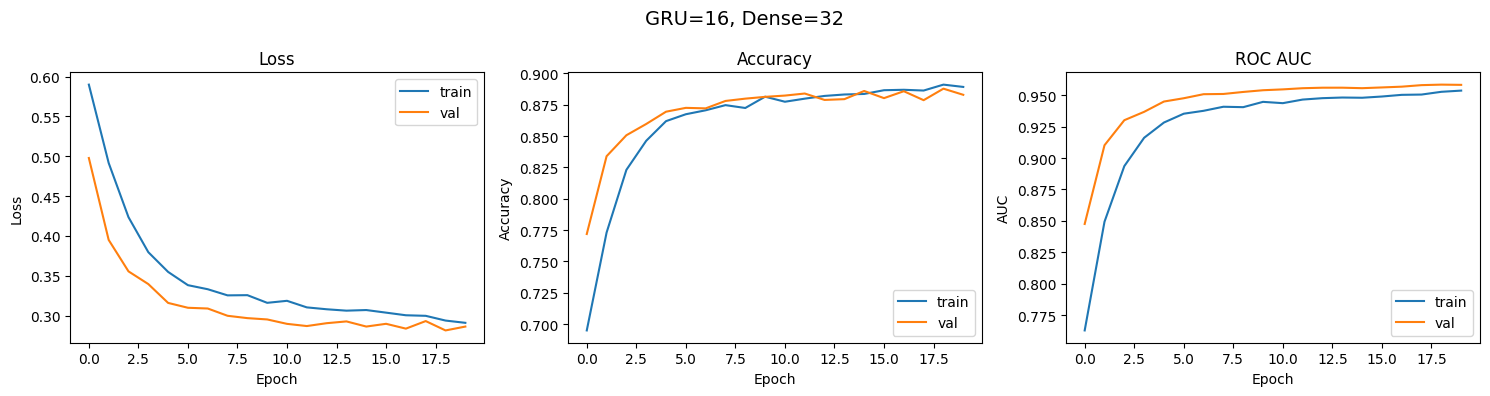

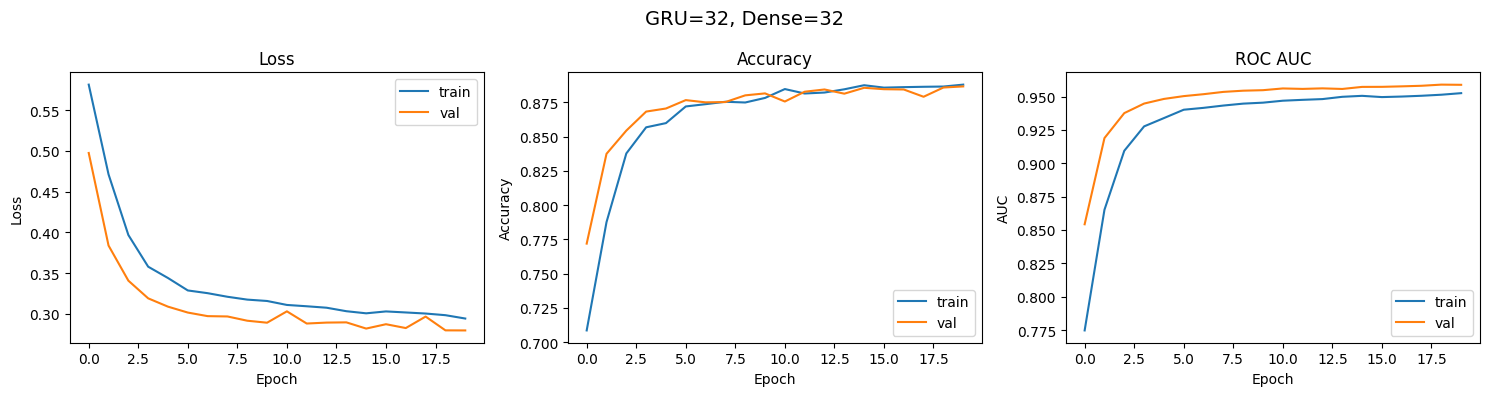

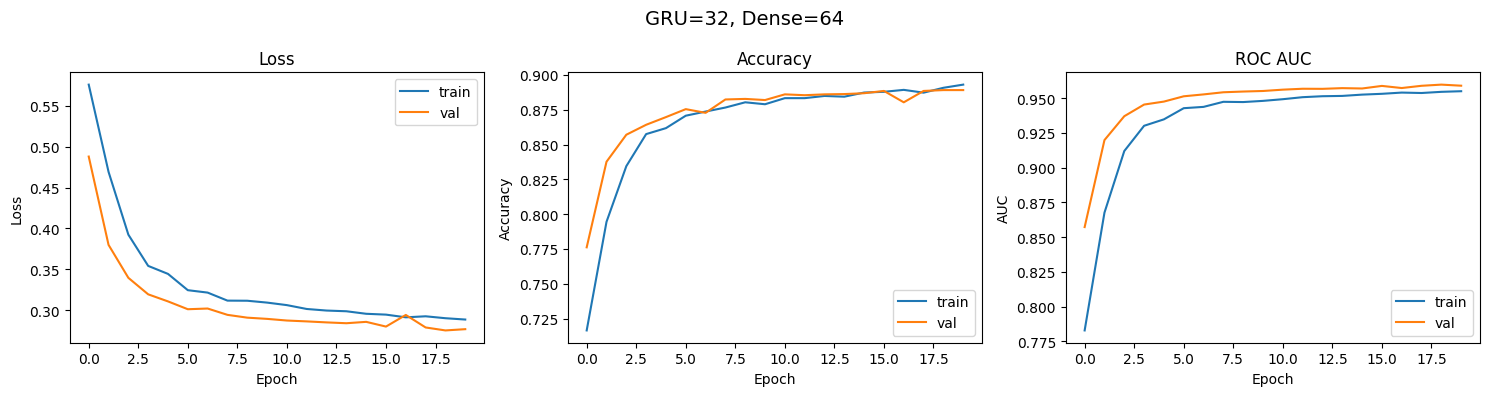

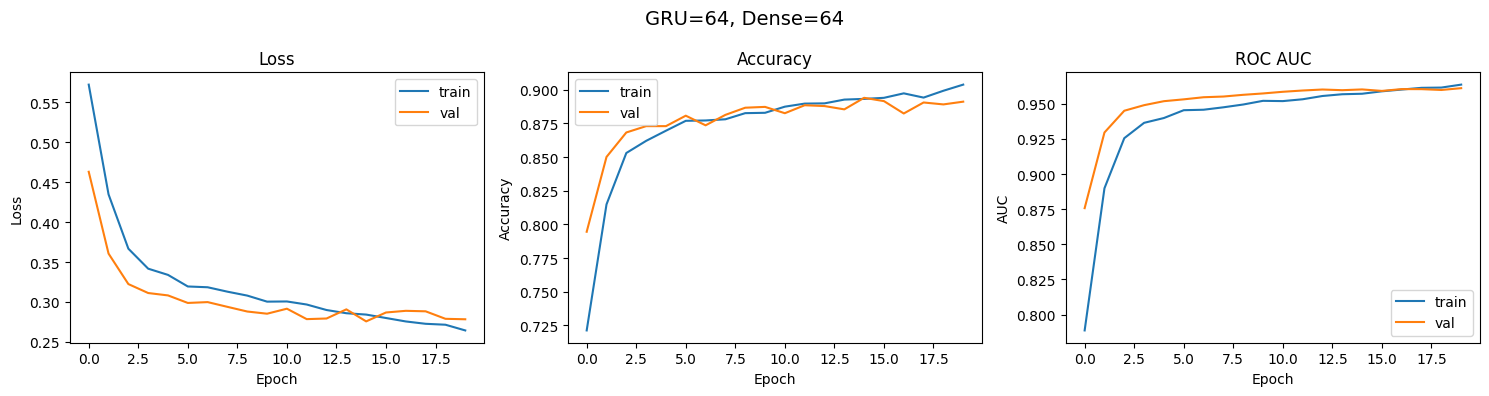

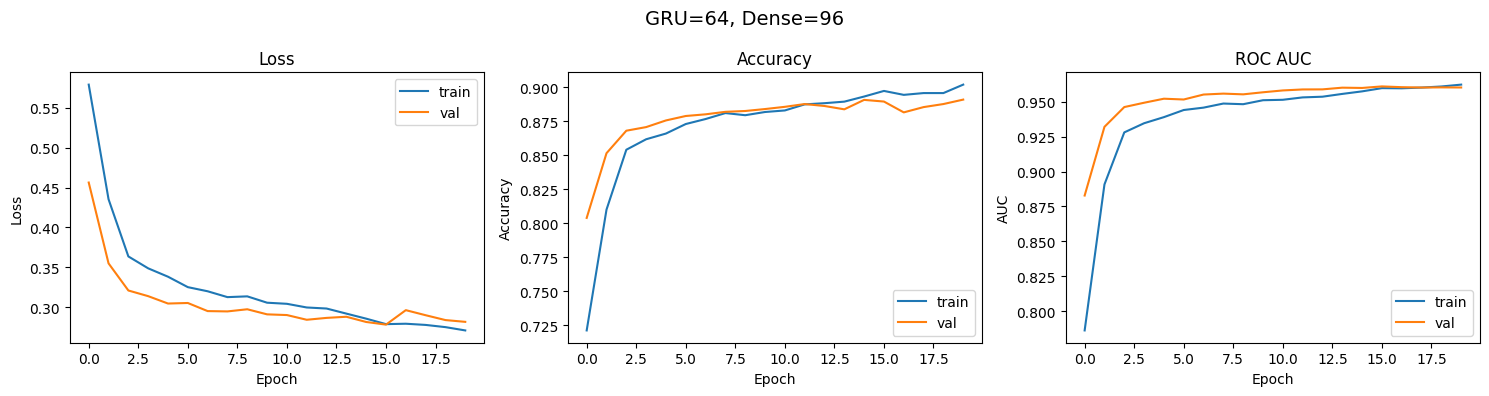

In [36]:
# plot each config
for (gru_units, dense_units), hist in histories2.items():
    title = f"GRU={gru_units}, Dense={dense_units}"
    plot_history_dict(hist, title=title)

In [37]:
best_gru_units = 32
best_dense_units = 32

Summary of Capacity Search:
Although larger configurations (e.g., 64–64 and 64–96) achieved slightly higher validation AUC values, their learning curves showed signs of instability and early overfitting. In contrast, the 32–32 configuration demonstrated smooth and stable convergence, with training and validation curves remaining closely aligned. This indicates better generalization and reliability. Therefore, the 32–32 setting is selected as the final configuration from the capacity search and will serve as the baseline for the next stage of regularization tuning.

--- Step 4: Regularization Search Space ----

In [40]:
# (gru_dropout, dense_dropout, mha_dropout, l2_reg)
search_space3 = [
    (0.2, 0.4, 0.1, 1e-4),  # baseline (balanced)
    (0.1, 0.3, 0.05, 1e-5), # weaker regularization
    (0.3, 0.5, 0.1, 1e-4),  # stronger dropout
    (0.2, 0.4, 0.1, 1e-3),  # stronger L2
]

In [41]:
results3 = []
histories3 = {}

In [42]:
# === Step 4: Regularization Search ===
results3 = []
histories3 = {}

for gru_do, dense_do, mha_do, l2reg in search_space3:
    print(f"\n===== Testing GRU_dropout={gru_do}, Dense_dropout={dense_do}, "
          f"MHA_dropout={mha_do}, L2={l2reg} =====")

    set_seed(42)

    # build model (capacity fixed at chosen config, e.g. 32-32)
    model = build_bigru_light(
        input_shape=(100, 768),
        gru_units=best_gru_units,
        gru_dropout=gru_do,
        mha_heads=4,
        mha_keydim=32,
        mha_dropout=mha_do,
        dense_units=best_dense_units,
        dense_dropout=dense_do,
        l2_reg=l2reg,
        learning_rate=best_lr,
        label_smoothing=0.01,
        clipnorm=1.0,
        optimizer=best_opt
    )

    # train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=64,
        verbose=0,
        callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True
        )]
    )

    # evaluate
    val_auc = model.evaluate(X_val, y_val, verbose=0)[2]  # index 2 = roc_auc
    print(f"Validation AUROC: {val_auc:.4f}")

    results3.append((gru_do, dense_do, mha_do, l2reg, val_auc))
    histories3[(gru_do, dense_do, mha_do, l2reg)] = history.history


===== Testing GRU_dropout=0.2, Dense_dropout=0.4, MHA_dropout=0.1, L2=0.0001 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9588

===== Testing GRU_dropout=0.1, Dense_dropout=0.3, MHA_dropout=0.05, L2=1e-05 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9606

===== Testing GRU_dropout=0.3, Dense_dropout=0.5, MHA_dropout=0.1, L2=0.0001 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9557

===== Testing GRU_dropout=0.2, Dense_dropout=0.4, MHA_dropout=0.1, L2=0.001 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9589


In [43]:
# === Step 4: Regularization Search Summary ===
results3_sorted = sorted(results3, key=lambda x: x[4], reverse=True)

print("\n===== Summary of Regularization Search =====")
for gru_do, dense_do, mha_do, l2, auc in results3_sorted:
    print(f"GRU_do={gru_do:.2f}, Dense_do={dense_do:.2f}, "
          f"MHA_do={mha_do:.2f}, L2={l2:.0e}  ->  val_roc_auc={auc:.4f}")


===== Summary of Regularization Search =====
GRU_do=0.10, Dense_do=0.30, MHA_do=0.05, L2=1e-05  ->  val_roc_auc=0.9606
GRU_do=0.20, Dense_do=0.40, MHA_do=0.10, L2=1e-03  ->  val_roc_auc=0.9589
GRU_do=0.20, Dense_do=0.40, MHA_do=0.10, L2=1e-04  ->  val_roc_auc=0.9588
GRU_do=0.30, Dense_do=0.50, MHA_do=0.10, L2=1e-04  ->  val_roc_auc=0.9557


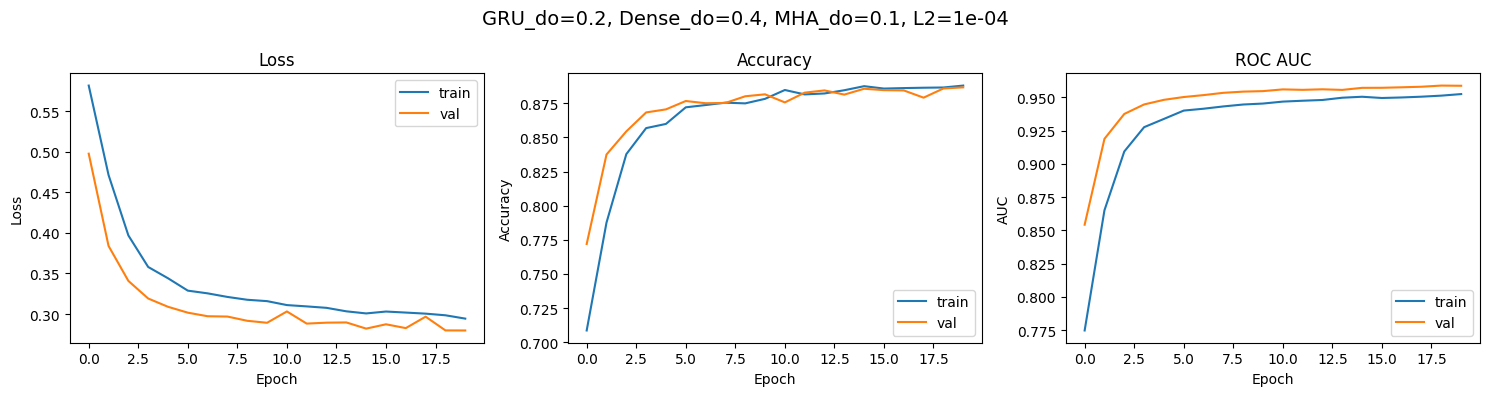

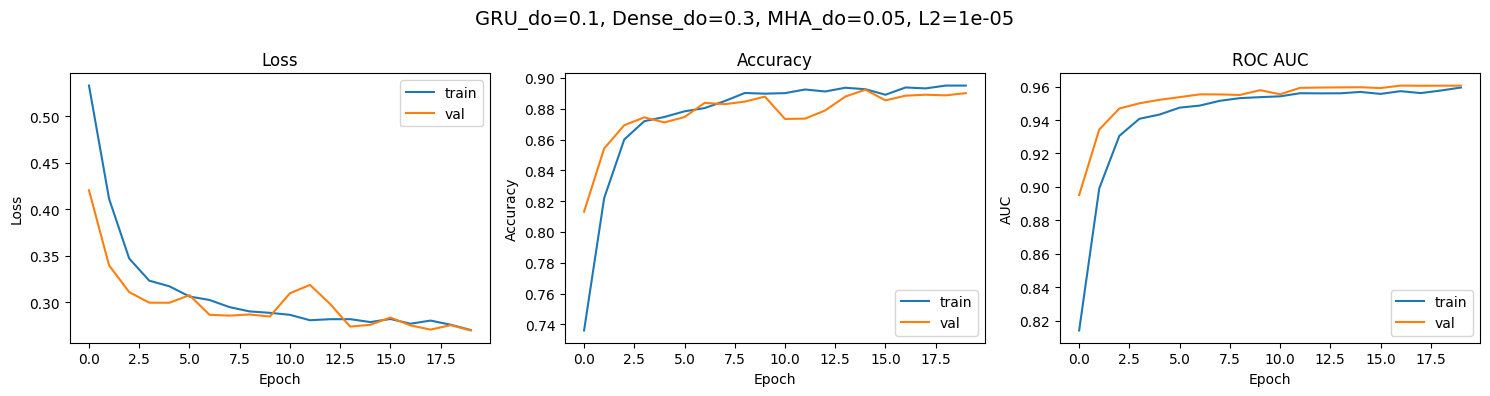

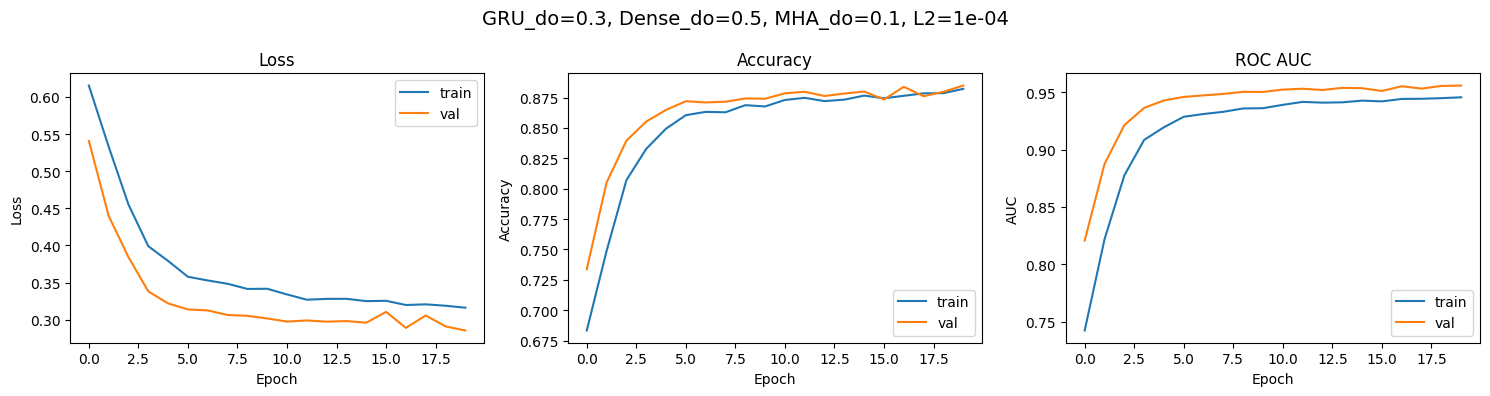

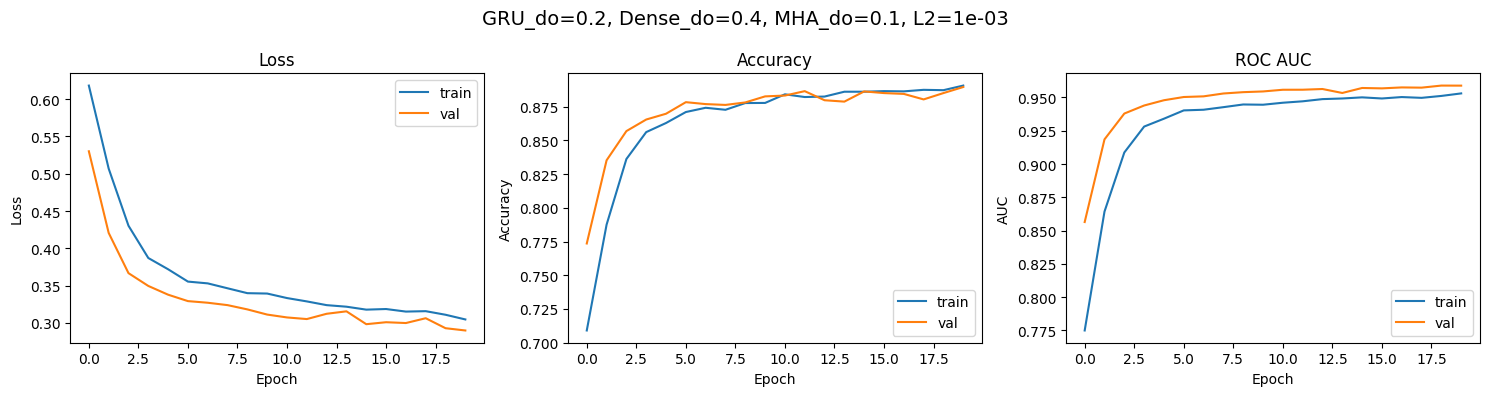

In [44]:
# plot each config
for (gru_do, dense_do, mha_do, l2), hist in histories3.items():
    title = f"GRU_do={gru_do}, Dense_do={dense_do}, MHA_do={mha_do}, L2={l2:.0e}"
    plot_history_dict(hist, title=title)

In [47]:
best_gru_dropout = 0.3
best_dense_dropout = 0.5
best_mha_dropout = 0.1
best_l2_reg = 1e-4

---Step 5: Fine-tuning MHA Parameters---

In [50]:
search_space4 = [
    (2, 32),   # smaller heads, light config
    (4, 32),   # baseline (current)
    (6, 32),   # more heads, same keydim
    (4, 16),   # reduced key_dim, lightweight control
]

In [51]:
results4 = []
histories4 = {}

In [52]:
for mha_heads, mha_keydim in search_space4:
    print(f"\n===== Testing MHA_heads={mha_heads}, MHA_keydim={mha_keydim} =====")

    set_seed(42)

    # build model (capacity + regularization fixed, only vary MHA)
    model = build_bigru_light(
        input_shape=(100, 768),
        gru_units=best_gru_units,       # from Step 3 (e.g., 32)
        gru_dropout=best_gru_dropout,   # from Step 4 (baseline/best)
        mha_heads=mha_heads,            # vary here
        mha_keydim=mha_keydim,          # vary here
        mha_dropout=best_mha_dropout,   # from Step 4 (baseline/best)
        dense_units=best_dense_units,   # from Step 3 (e.g., 32)
        dense_dropout=best_dense_dropout,
        l2_reg=best_l2_reg,
        learning_rate=best_lr,          # from Step 2
        label_smoothing=0.01,
        clipnorm=1.0,
        optimizer=best_opt              # from Step 2
    )

    # train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=64,
        verbose=0,
        callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True
        )]
    )

    # evaluate
    val_auc = model.evaluate(X_val, y_val, verbose=0)[2]  # index 2 = roc_auc
    print(f"Validation AUROC: {val_auc:.4f}")

    results4.append((mha_heads, mha_keydim, val_auc))
    histories4[(mha_heads, mha_keydim)] = history.history


===== Testing MHA_heads=2, MHA_keydim=32 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9554

===== Testing MHA_heads=4, MHA_keydim=32 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9557

===== Testing MHA_heads=6, MHA_keydim=32 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9563

===== Testing MHA_heads=4, MHA_keydim=16 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9561


In [53]:
# === Summary (sorted by val_auc) ===
results4_sorted = sorted(results4, key=lambda x: x[2], reverse=True)

print("\n===== Summary of MHA Parameter Search =====")
for heads, keydim, auc in results4_sorted:
    print(f"MHA_heads={heads:2d}, keydim={keydim:2d}  ->  val_roc_auc={auc:.4f}")


===== Summary of MHA Parameter Search =====
MHA_heads= 6, keydim=32  ->  val_roc_auc=0.9563
MHA_heads= 4, keydim=16  ->  val_roc_auc=0.9561
MHA_heads= 4, keydim=32  ->  val_roc_auc=0.9557
MHA_heads= 2, keydim=32  ->  val_roc_auc=0.9554


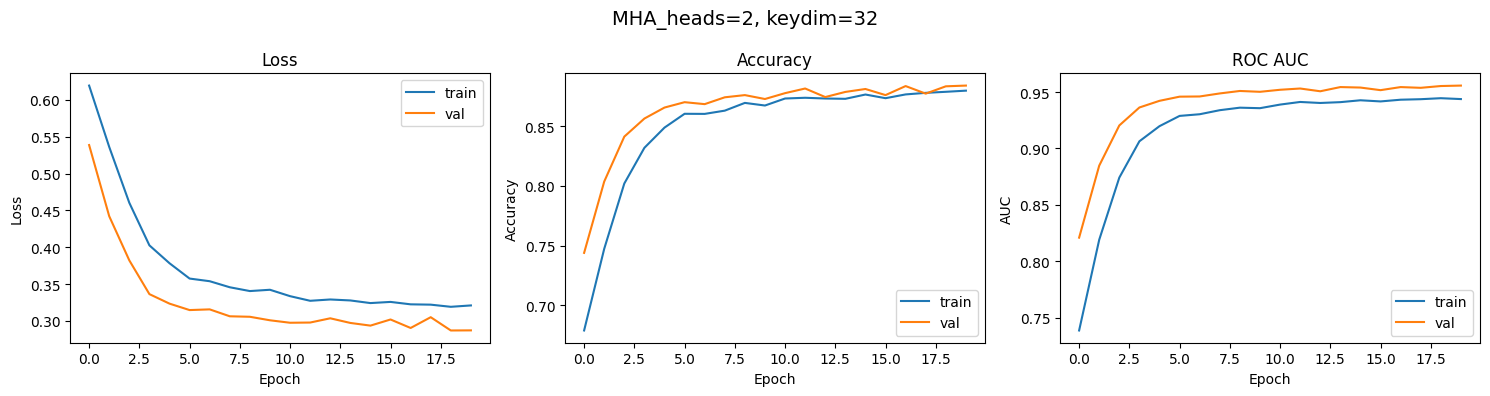

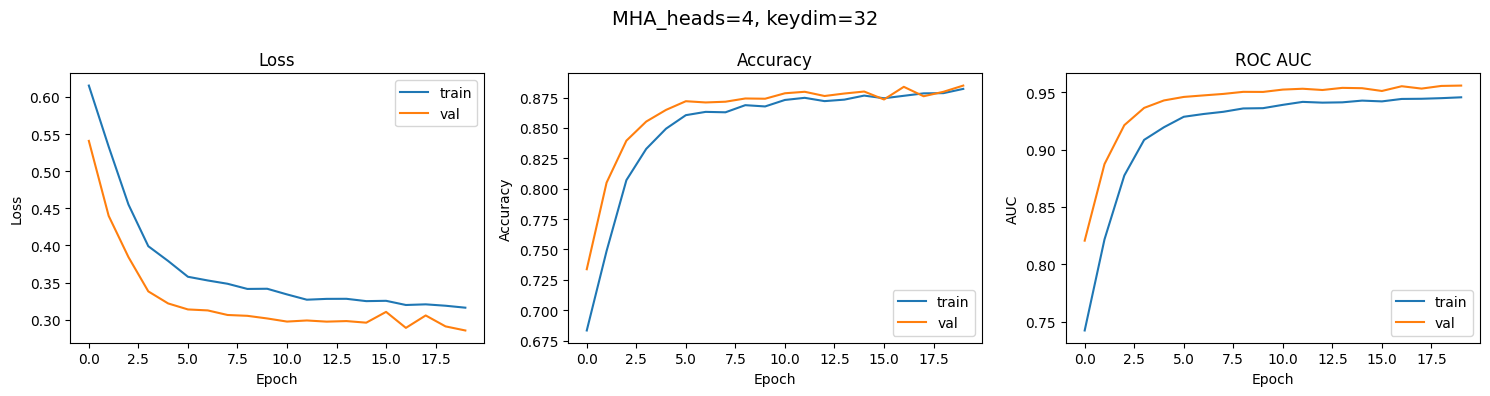

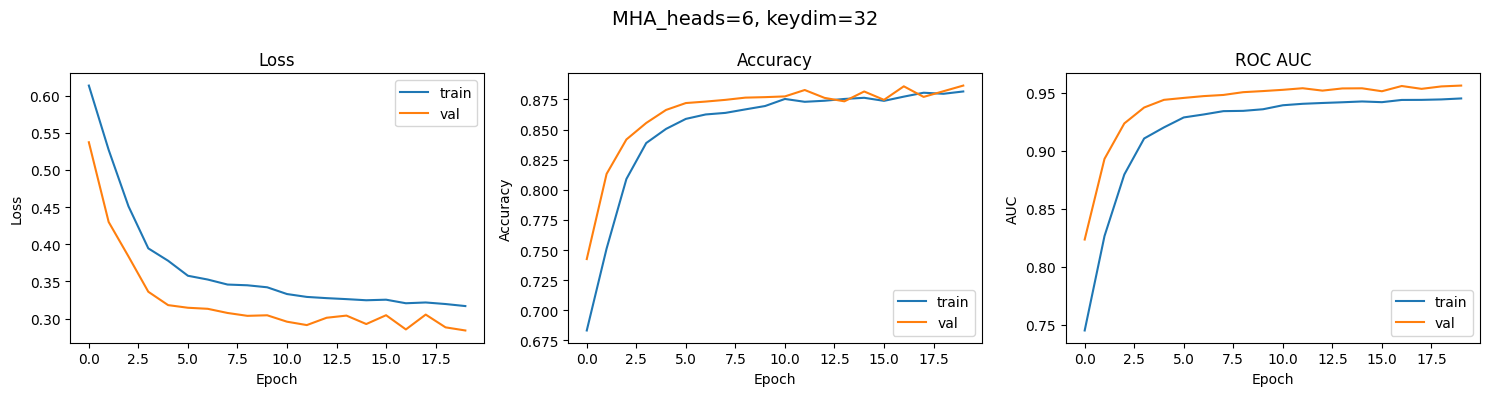

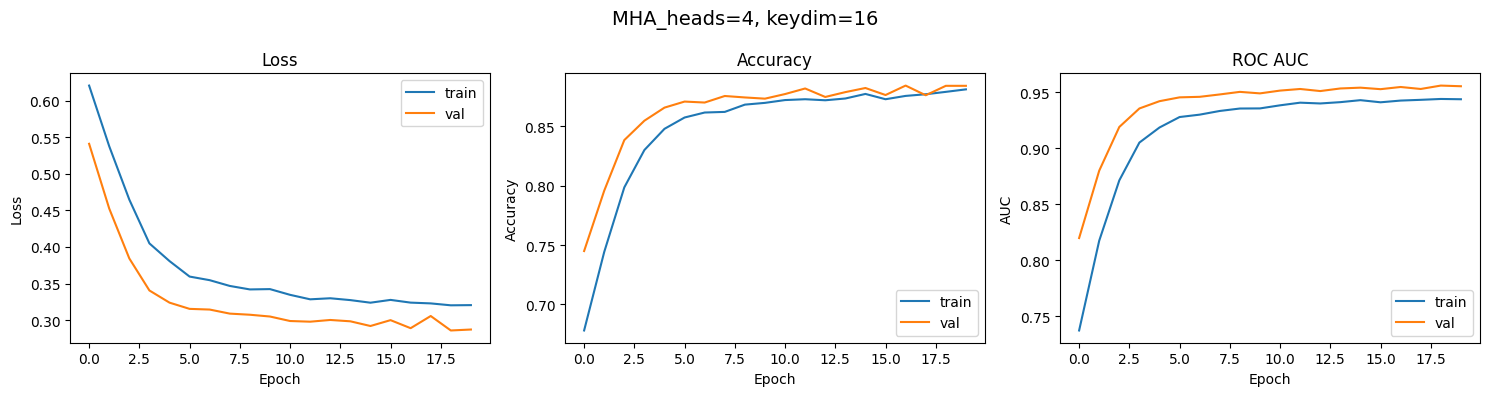

In [54]:
# === Plot curves for each config ===
for (heads, keydim), hist in histories4.items():
    title = f"MHA_heads={heads}, keydim={keydim}"
    plot_history_dict(hist, title=title)

In [60]:
best_mha_heads = 4
best_mha_keydim = 16

---Label Smoothing Search---

In [61]:
# === Step 6: Label Smoothing Search ===
search_space5 = [0.0, 0.01, 0.05, 0.1]  # candidate label smoothing values

In [62]:
results5 = []
histories5 = {}

In [63]:
for ls in search_space5:
    print(f"\n===== Testing Label Smoothing={ls} =====")

    set_seed(42)

    # build model (use best configs from previous steps)
    model = build_bigru_light(
        input_shape=(100, 768),
        gru_units=best_gru_units,        # e.g. 32
        gru_dropout=best_gru_dropout,    # from Step 4
        mha_heads=best_mha_heads,        # from Step 5
        mha_keydim=best_mha_keydim,      # from Step 5
        mha_dropout=best_mha_dropout,    # from Step 4
        dense_units=best_dense_units,    # e.g. 32
        dense_dropout=best_dense_dropout,# from Step 4
        l2_reg=best_l2_reg,                  # from Step 4
        learning_rate=best_lr,           # from Step 2
        label_smoothing=ls,              # <--- testing here
        clipnorm=1.0,                    # keep fixed
        optimizer=best_opt
    )

    # train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=64,
        verbose=0,
        callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True
        )]
    )

    # evaluate
    val_auc = model.evaluate(X_val, y_val, verbose=0)[2]  # index 2 = roc_auc
    print(f"Validation AUROC: {val_auc:.4f}")

    results5.append((ls, val_auc))
    histories5[ls] = history.history


===== Testing Label Smoothing=0.0 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9559

===== Testing Label Smoothing=0.01 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9561

===== Testing Label Smoothing=0.05 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9563

===== Testing Label Smoothing=0.1 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9567


In [64]:
# === Summary ===
results5_sorted = sorted(results5, key=lambda x: x[1], reverse=True)
print("\n===== Summary of Label Smoothing Search =====")
for ls, auc in results5_sorted:
    print(f"Label Smoothing={ls:.2f}  ->  val_roc_auc={auc:.4f}")


===== Summary of Label Smoothing Search =====
Label Smoothing=0.10  ->  val_roc_auc=0.9567
Label Smoothing=0.05  ->  val_roc_auc=0.9563
Label Smoothing=0.01  ->  val_roc_auc=0.9561
Label Smoothing=0.00  ->  val_roc_auc=0.9559


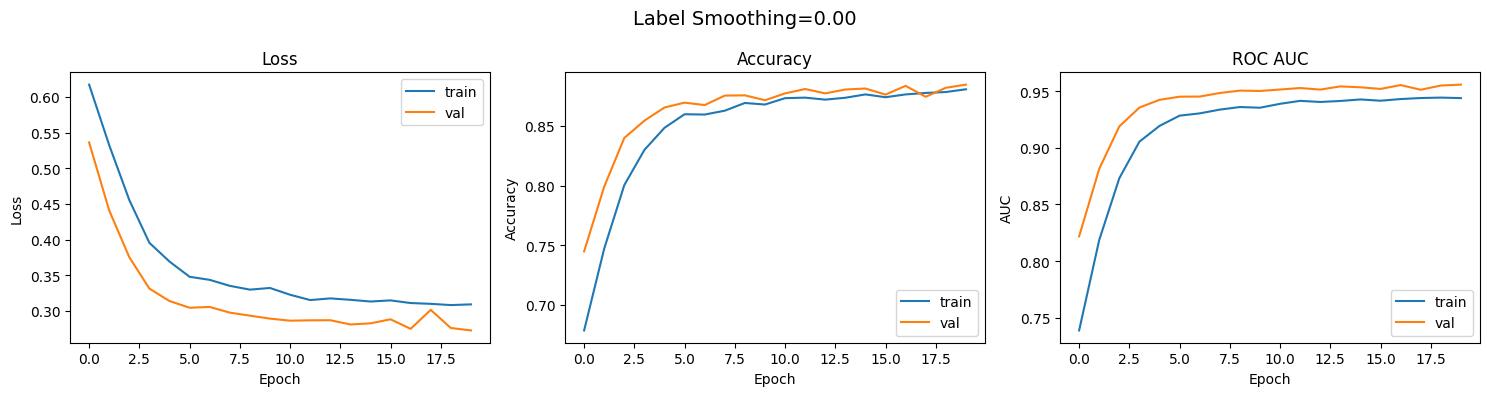

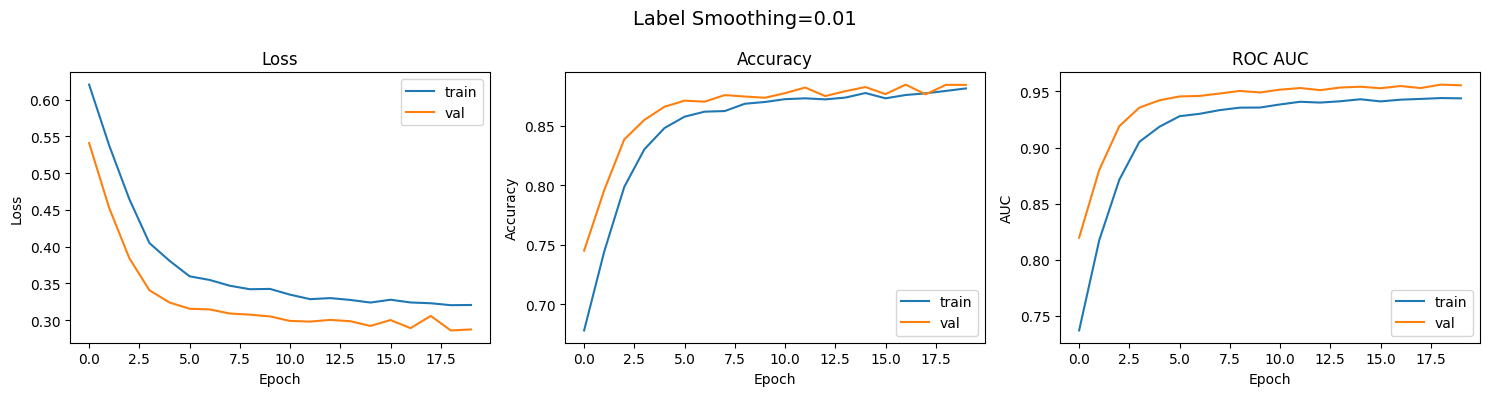

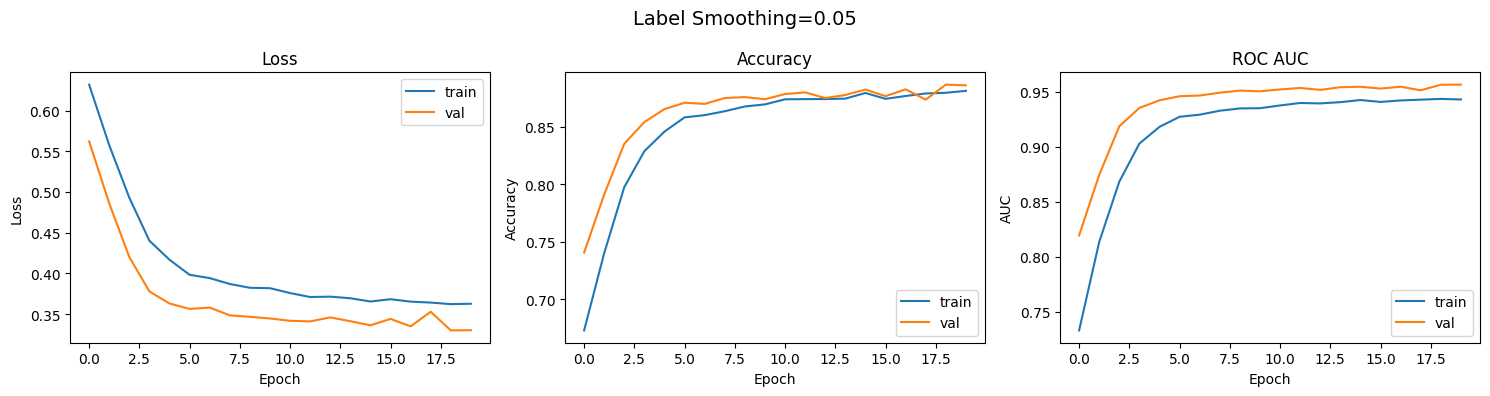

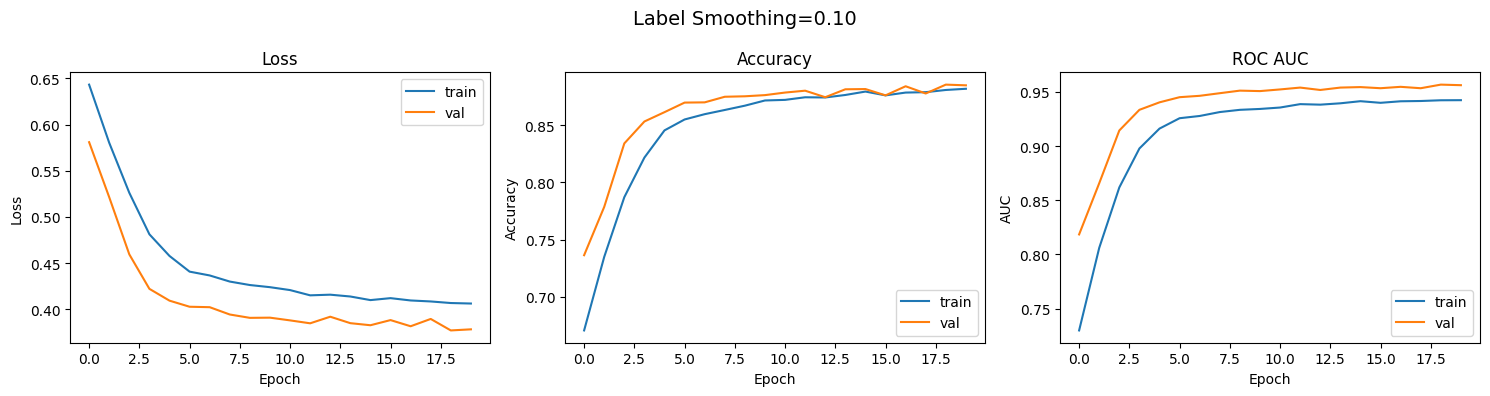

In [65]:
# === Plot Curves ===
for ls, hist in histories5.items():
    title = f"Label Smoothing={ls:.2f}"
    plot_history_dict(hist, title=title)

In [66]:
best_ls = 0.1

---Early Stopping Patience Search---

In [67]:
# === Step 7: Early Stopping Patience Search ===
search_space6 = [5, 8, 10]

results6 = []
histories6 = {}

In [68]:
for patience in search_space6:
    print(f"\n===== Testing EarlyStopping patience={patience} =====")

    set_seed(42)

    model = build_bigru_light(
        input_shape=(100, 768),
        gru_units=best_gru_units,
        gru_dropout=best_gru_dropout,
        mha_heads=best_mha_heads,
        mha_keydim=best_mha_keydim,
        mha_dropout=best_mha_dropout,
        dense_units=best_dense_units,
        dense_dropout=best_dense_dropout,
        l2_reg=best_l2_reg,
        learning_rate=best_lr,
        label_smoothing=best_ls,
        clipnorm=1.0,
        optimizer=best_opt
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=40,  # give more room to exploit patience
        batch_size=64,
        verbose=0,
        callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=patience, restore_best_weights=True
        )]
    )

    val_auc = model.evaluate(X_val, y_val, verbose=0)[2]
    print(f"Validation AUROC: {val_auc:.4f}")

    results6.append((patience, val_auc))
    histories6[patience] = history.history


===== Testing EarlyStopping patience=5 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9567

===== Testing EarlyStopping patience=8 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9604

===== Testing EarlyStopping patience=10 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9604


In [69]:
# === Summary ===
results6_sorted = sorted(results6, key=lambda x: x[1], reverse=True)
print("\n===== Summary of EarlyStopping Patience Search =====")
for patience, auc in results6_sorted:
    print(f"Patience={patience:2d}  ->  val_roc_auc={auc:.4f}")


===== Summary of EarlyStopping Patience Search =====
Patience= 8  ->  val_roc_auc=0.9604
Patience=10  ->  val_roc_auc=0.9604
Patience= 5  ->  val_roc_auc=0.9567


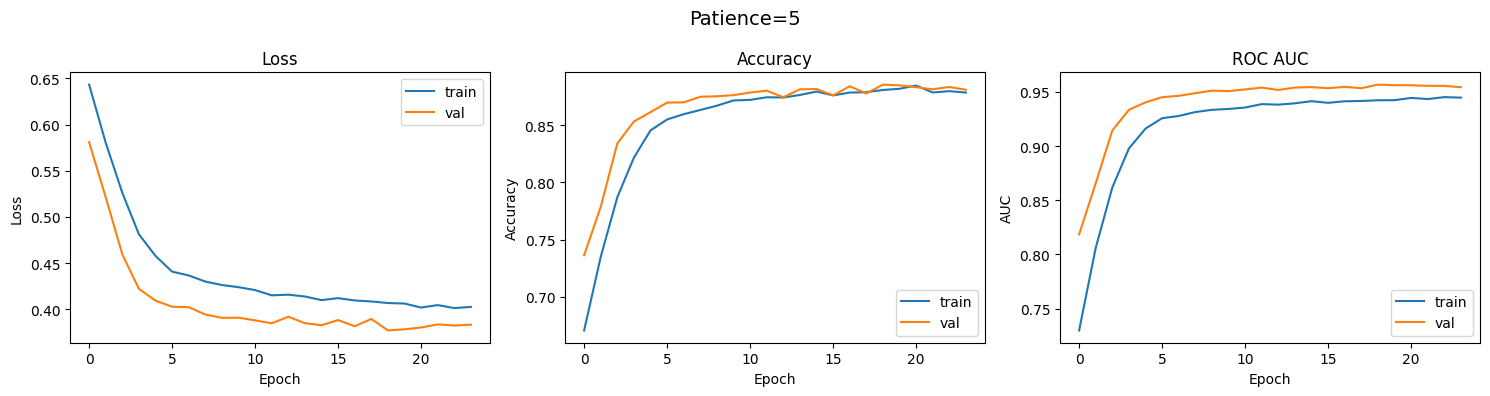

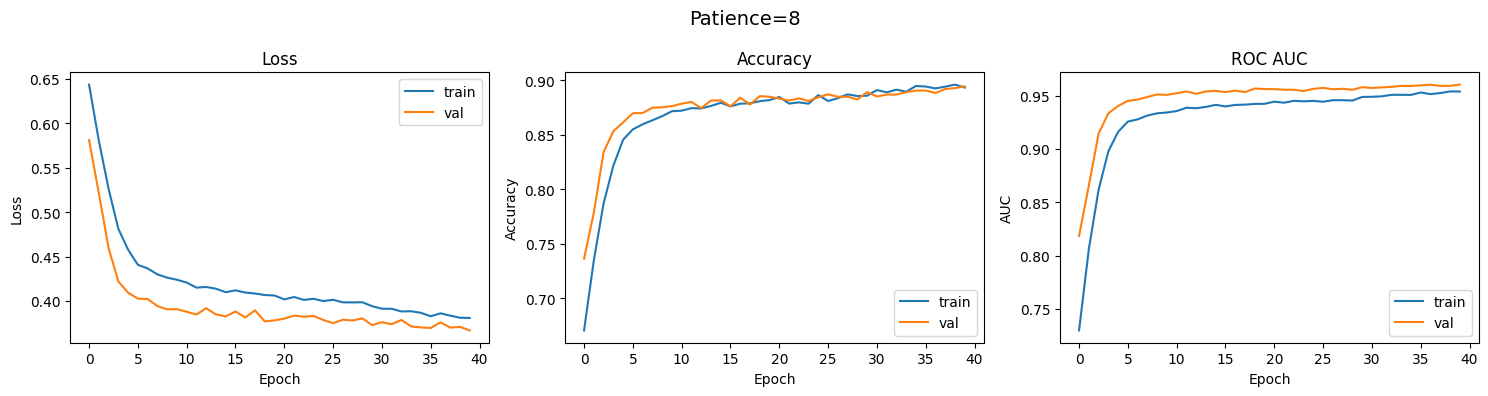

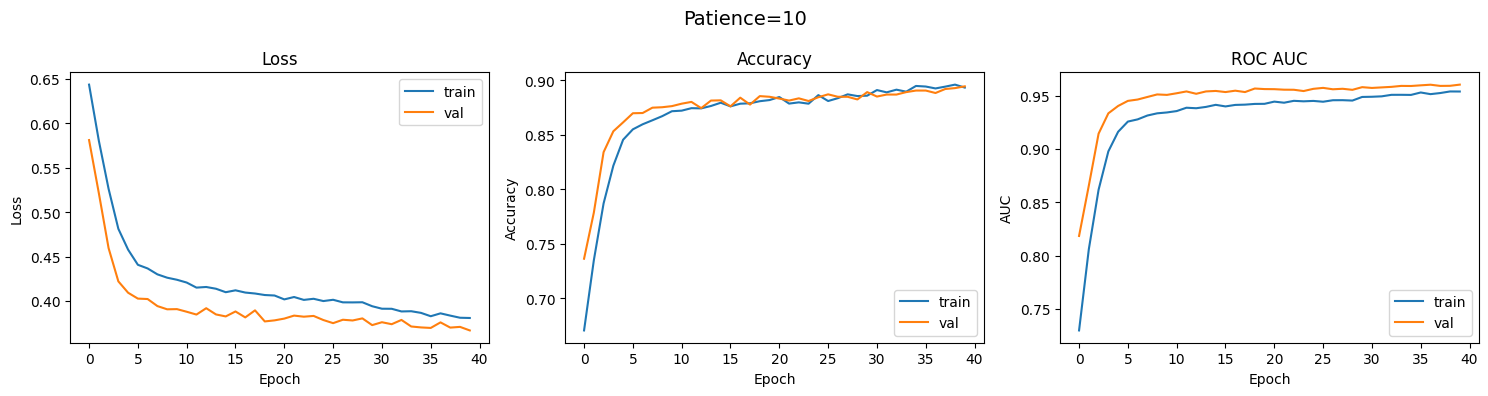

In [70]:
# === Plot Curves ===
for patience, hist in histories6.items():
    title = f"Patience={patience}"
    plot_history_dict(hist, title=title)

--Try LR Scheduler Search---

In [76]:
# === Step 6: Scheduler Search ===
results7 = []
histories7 = {}

import math
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint

# Cosine annealing schedule
def cosine_annealing(epoch, lr_max=best_lr, T_max=20, eta_min=1e-6):
    return eta_min + 0.5 * (lr_max - eta_min) * (1 + math.cos(math.pi * epoch / T_max))

In [77]:
search_space7 = {
    "earlystop": [EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=0)],
    "reduceLR": [
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=0)
    ],
    "cosine": [
        EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=0),
        LearningRateScheduler(cosine_annealing, verbose=0)
    ]
}

In [78]:
for sched_name, callbacks in search_space7.items():
    print(f"\n===== Testing Scheduler: {sched_name} =====")

    set_seed(42)

    model = build_bigru_light(
        input_shape=(100, 768),
        gru_units=best_gru_units,
        gru_dropout=best_gru_dropout,
        mha_heads=best_mha_heads,
        mha_keydim=best_mha_keydim,
        mha_dropout=best_mha_dropout,
        dense_units=best_dense_units,
        dense_dropout=best_dense_dropout,
        l2_reg=best_l2_reg,
        learning_rate=best_lr,
        label_smoothing=best_ls,
        clipnorm=1.0,
        optimizer=best_opt
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=40,
        batch_size=64,
        verbose=0,
        callbacks=callbacks
    )

    val_auc = model.evaluate(X_val, y_val, verbose=0)[2]
    print(f"Validation AUROC: {val_auc:.4f}")

    results7.append((sched_name, val_auc))
    histories7[sched_name] = history.history


===== Testing Scheduler: earlystop =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9567

===== Testing Scheduler: reduceLR =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9560

===== Testing Scheduler: cosine =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9485


In [79]:
# === Summary ===
results7_sorted = sorted(results7, key=lambda x: x[1], reverse=True)
print("\n===== Summary of Scheduler Search =====")
for sched, auc in results7_sorted:
    print(f"{sched:10s}  ->  val_roc_auc={auc:.4f}")


===== Summary of Scheduler Search =====
earlystop   ->  val_roc_auc=0.9567
reduceLR    ->  val_roc_auc=0.9560
cosine      ->  val_roc_auc=0.9485


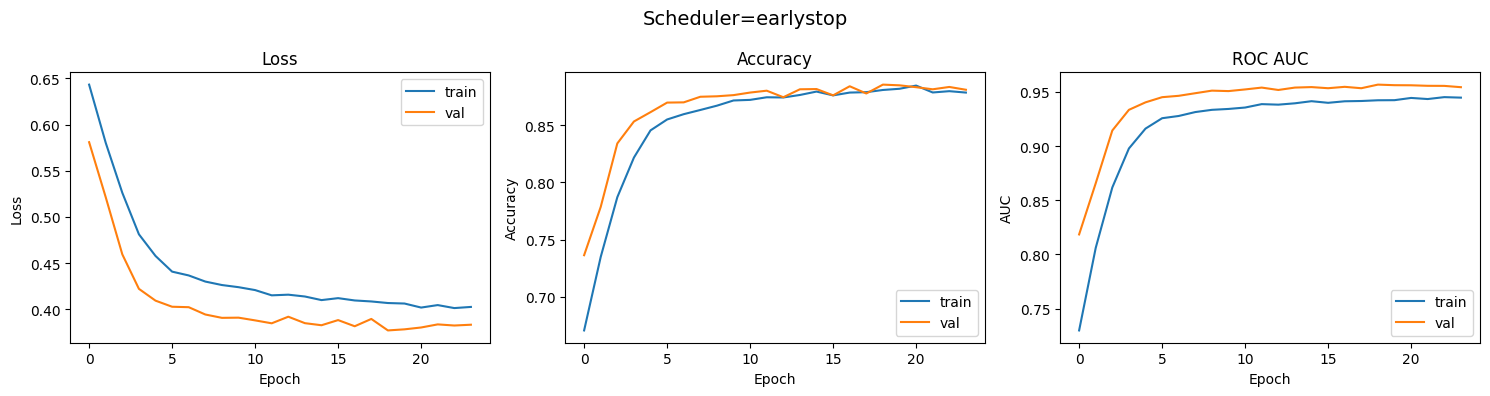

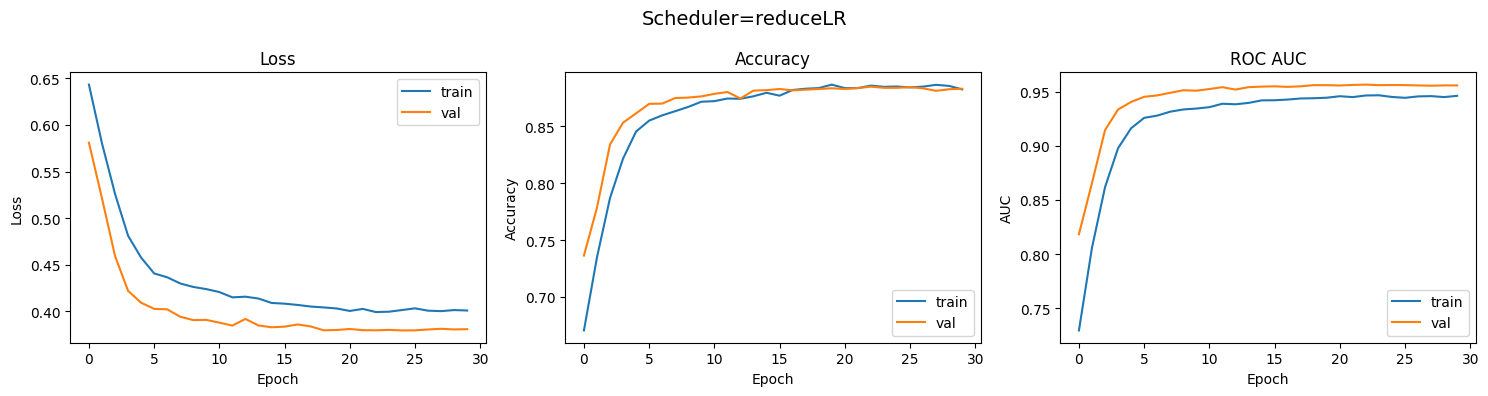

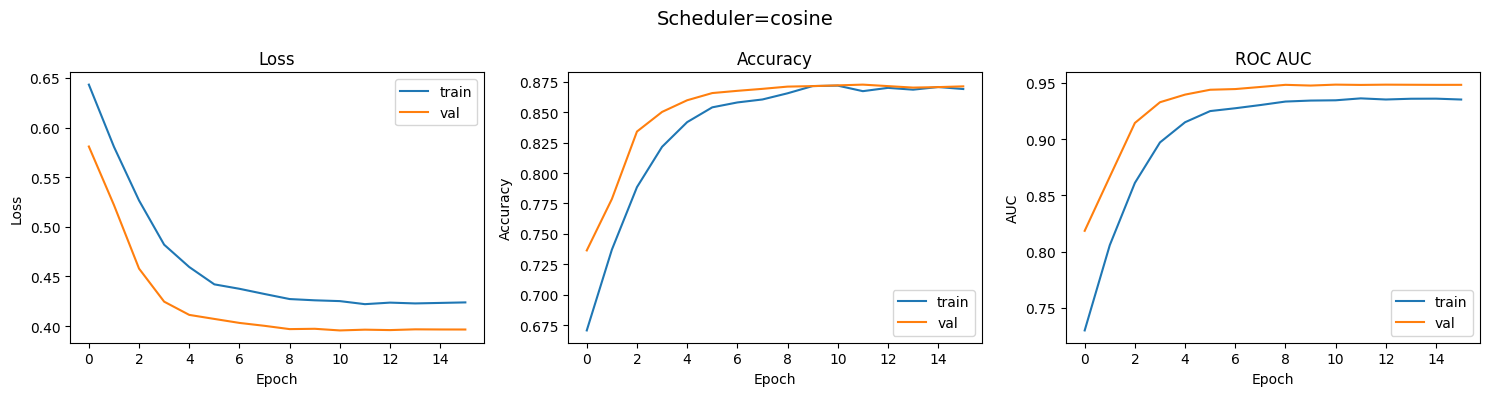

In [80]:
# === Plot curves ===
for sched, hist in histories7.items():
    title = f"Scheduler={sched}"
    plot_history_dict(hist, title=title)

In [88]:
best_es = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1
    )
]

---Train with final BiGRU Model---

In [86]:
best_config = {
    "gru_units": best_gru_units,
    "gru_dropout": best_gru_dropout,
    "mha_heads": best_mha_heads,
    "mha_keydim": best_mha_keydim,
    "mha_dropout": best_mha_dropout,
    "dense_units": best_dense_units,
    "dense_dropout": best_dense_dropout,
    "l2_reg": best_l2_reg,
    "learning_rate": best_lr,
    "label_smoothing": best_ls,
    "clipnorm": 1.0,
    "optimizer": best_opt
}

print("Best Config:")
for k, v in best_config.items():
    print(f"  {k}: {v}")

Best Config:
  gru_units: 32
  gru_dropout: 0.3
  mha_heads: 4
  mha_keydim: 16
  mha_dropout: 0.1
  dense_units: 32
  dense_dropout: 0.5
  l2_reg: 0.0001
  learning_rate: 0.0003
  label_smoothing: 0.1
  clipnorm: 1.0
  optimizer: adam


In [87]:
set_seed(42)

final_gru = build_bigru_light(
        input_shape=(100, 768),
        gru_units=best_gru_units,
        gru_dropout=best_gru_dropout,
        mha_heads=best_mha_heads,
        mha_keydim=best_mha_keydim,
        mha_dropout=best_mha_dropout,
        dense_units=best_dense_units,
        dense_dropout=best_dense_dropout,
        l2_reg=best_l2_reg,
        learning_rate=best_lr,
        label_smoothing=best_ls,
        clipnorm=1.0,
        optimizer=best_opt
    )

final_gru.summary()

[INFO] Seed set to 42, deterministic ops enabled


Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_39      │ (None, 100, 768)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_78 (Lambda)  │ (None, 100)       │          0 │ input_layer_39[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_37    │ (None, 100, 64)   │    153,984 │ input_layer_39[0… │
│ (Bidirectional)     │                   │            │ lambda_78[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_37         │ (None, 1, 1, 100) │          0 │ lambda_78[0][0]   │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 100, 64)   │     16,640 │ bidirectional_37… │
│ (MultiHeadAttentio… │                   │            │ bidirectional_37… │
│                     │                   │            │ get_item_37[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_37 (Add)        │ (None, 100, 64)   │          0 │ bidirectional_37… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 100, 64)   │        128 │ add_37[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_… │ (None, 100, 64)   │          0 │ layer_normalizat… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_79 (Lambda)  │ (None, 64)        │          0 │ spatial_dropout1… │
│                     │                   │            │ lambda_78[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_79 (Dense)    │ (None, 32)        │      2,080 │ lambda_79[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_78          │ (None, 32)        │          0 │ dense_79[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_80 (Dense)    │ (None, 1)         │         33 │ dropout_78[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 172,865 (675.25 KB)

 Trainable params: 172,865 (675.25 KB)

 Non-trainable params: 0 (0.00 B)

In [90]:
history = final_gru.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=64,
    verbose=1,
    callbacks=best_es
)

Epoch 1/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.6335 - loss: 0.6942 - roc_auc: 0.6838 - val_accuracy: 0.7364 - val_loss: 0.5809 - val_roc_auc: 0.8184 - learning_rate: 3.0000e-04
Epoch 2/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.7196 - loss: 0.5888 - roc_auc: 0.7936 - val_accuracy: 0.7786 - val_loss: 0.5213 - val_roc_auc: 0.8657 - learning_rate: 3.0000e-04
Epoch 3/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.7719 - loss: 0.5372 - roc_auc: 0.8506 - val_accuracy: 0.8342 - val_loss: 0.4594 - val_roc_auc: 0.9144 - learning_rate: 3.0000e-04
Epoch 4/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8144 - loss: 0.4915 - roc_auc: 0.8900 - val_accuracy: 0.8534 - val_loss: 0.4221 - val_roc_auc: 0.9335 - learning_rate: 3.0000e-04
Epoch 5/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8437 - loss: 0.4609 - roc_auc: 0.9143 - val_accuracy: 0.8615 - val_loss: 0.4093 - val_roc_auc: 0.9404 - learning_rate: 3.0000e-04
Epoch 6/40
179

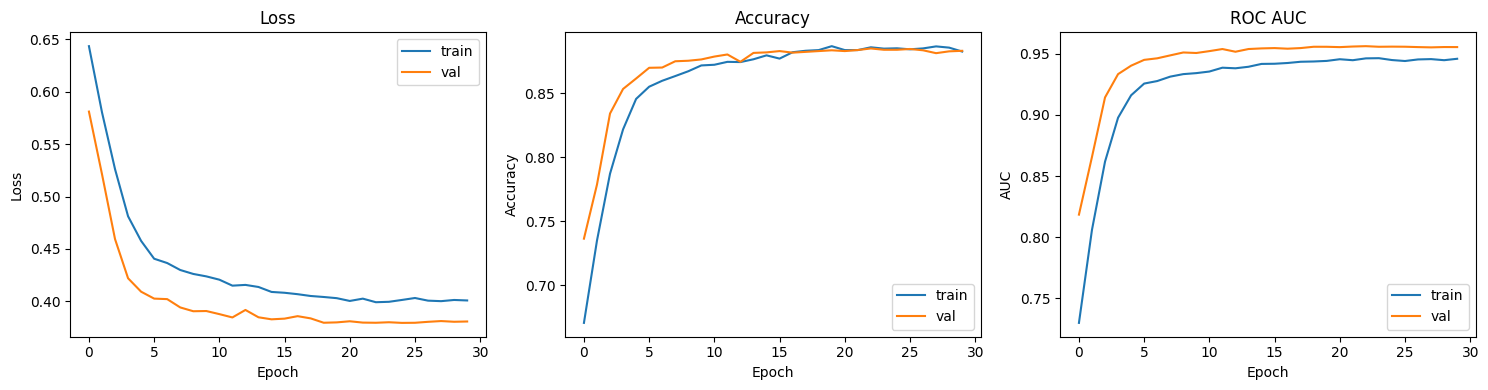

In [91]:
plot_history(history)

In [95]:
evaluate_model(model=final_gru, X=X_val_external, y=y_val_external, ids=val_ids, agg="mean")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Sample-level AUROC: 0.777
Classification Report (sample-level):
              precision    recall  f1-score   support

           0      0.703     0.823     0.758       124
           1      0.707     0.552     0.620        96

    accuracy                          0.705       220
   macro avg      0.705     0.687     0.689       220
weighted avg      0.705     0.705     0.698       220

Doc-level AUROC (mean): 0.93


---Extract the result on the test dataset--

In [96]:
y_test_prob_gru = final_gru.predict(X_test).ravel()
df_probs_gru = pd.DataFrame({'id': test_ids, 'prob': y_test_prob_gru})
final_probs_gru = df_probs_gru.groupby('id')['prob'].mean().reset_index()
print(final_probs_gru.head())

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
   id      prob
0  15  0.132598
1  16  0.224788
2  17  0.106659
3  18  0.400119
4  19  0.244022


In [97]:
out_dir = "/content/drive/MyDrive/my_exports"  # save to my google drive
os.makedirs(out_dir, exist_ok=True)

save_path = os.path.join(out_dir, "final_probs_gru.csv")
final_probs_gru.to_csv(save_path, index=False, encoding="utf-8")
print("Saved to:", save_path)

Saved to: /content/drive/MyDrive/my_exports/final_probs_gru.csv


In [101]:
import datetime

def save_model(model, base_name="final_gru", out_dir="/content/drive/MyDrive/my_exports"):
    """
    Save a trained Keras model in both `.keras` (recommended) and `.h5` (legacy) formats.
    """
    os.makedirs(out_dir, exist_ok=True)

    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    file_name = f"{base_name}_{timestamp}"

    keras_path = os.path.join(out_dir, file_name + ".keras")
    model.save(keras_path)

    h5_path = os.path.join(out_dir, file_name + ".h5")
    model.save(h5_path)

    print(f"✅ Model saved:\n  - {keras_path}\n  - {h5_path}")

In [102]:
save_model(final_gru, base_name="final_gru")

✅ Model saved:
  - /content/drive/MyDrive/my_exports/final_gru_20250818_102649.keras
  - /content/drive/MyDrive/my_exports/final_gru_20250818_102649.h5


---Once we done the BiGRU part, we still want to try the MLP performance -------

Start from here are optimizing MLP:

---Step 1: Capacity Search---

In [104]:
# === Step 1: Capacity Search ===
search_space1_mlp = [
    (64, 32),     # small baseline
    (128, 64),    # medium (likely good)
    (256, 128),   # large capacity
]

In [105]:
results1_mlp = []
histories1_mlp = {}

In [106]:
for h1, h2 in search_space1_mlp:
    print(f"\n===== Testing hidden1={h1}, hidden2={h2} =====")
    set_seed(42)

    model = build_mlp(
        input_shape=(100, 768),
        hidden1=h1,
        hidden2=h2,
        dropout=0.4,
        l2_reg=1e-4,
        learning_rate=1e-4,
        label_smoothing=0.01,
        clipnorm=1.0,
        optimizer="adam"
    )

    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=64,
        verbose=0,
        callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True)]
    )

    val_auc = model.evaluate(X_val, y_val, verbose=0)[2]  # index 2 = roc_auc
    print(f"Validation AUROC: {val_auc:.4f}")

    results1_mlp.append((h1, h2, val_auc))
    histories1_mlp[(h1, h2)] = history.history


===== Testing hidden1=64, hidden2=32 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9483

===== Testing hidden1=128, hidden2=64 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9517

===== Testing hidden1=256, hidden2=128 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9553


In [107]:
# sort results
results1_mlp_sorted = sorted(results1_mlp, key=lambda x: x[2], reverse=True)
print("\n===== Summary of Capacity Search =====")
for h1, h2, auc in results1_mlp_sorted:
    print(f"hidden1={h1:3d}, hidden2={h2:3d}  ->  val_roc_auc={auc:.4f}")


===== Summary of Capacity Search =====
hidden1=256, hidden2=128  ->  val_roc_auc=0.9553
hidden1=128, hidden2= 64  ->  val_roc_auc=0.9517
hidden1= 64, hidden2= 32  ->  val_roc_auc=0.9483


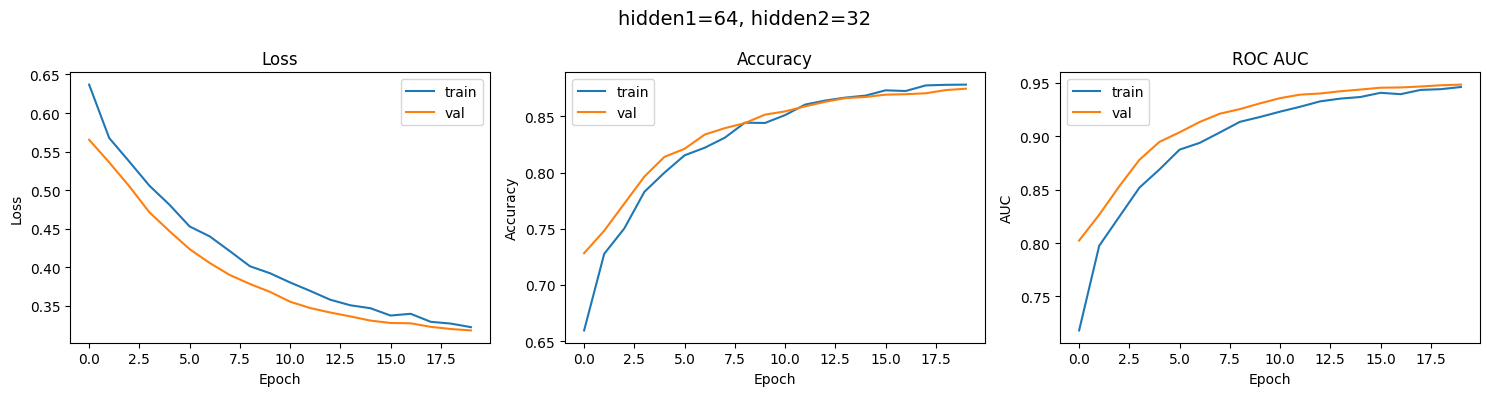

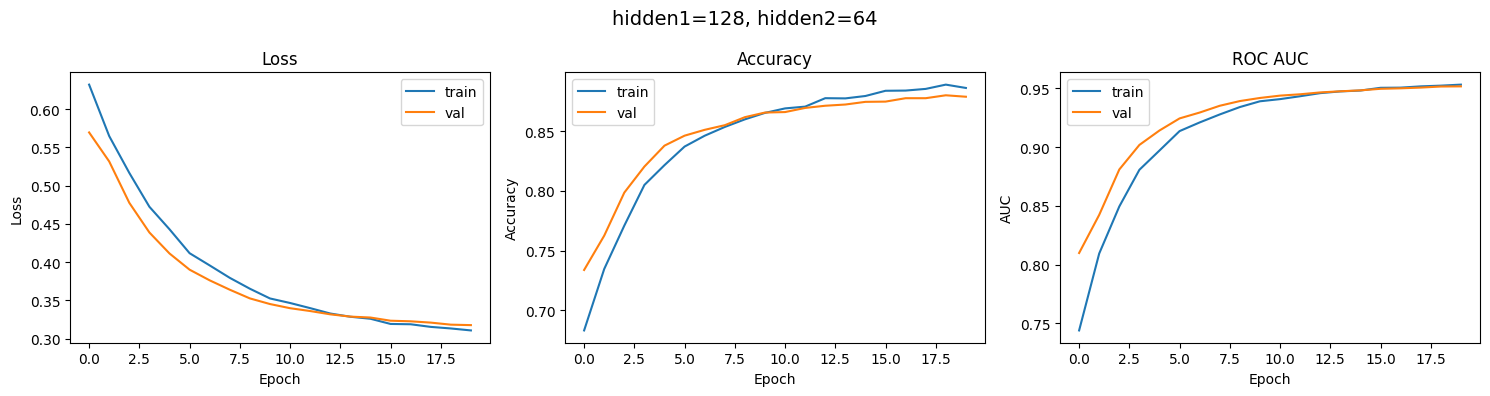

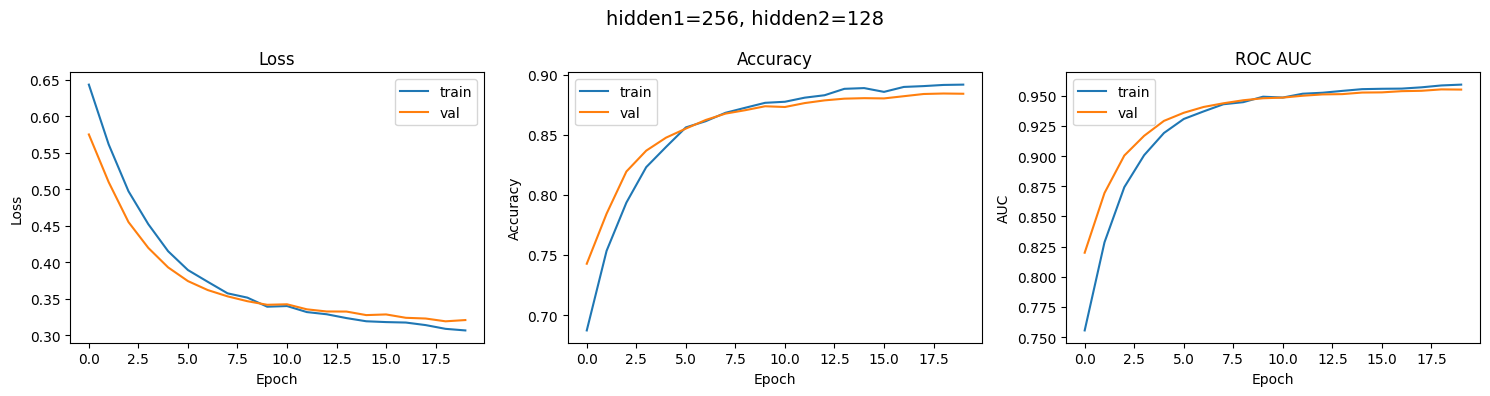

In [108]:
# === Plot curves ===
for (h1, h2), hist in histories1_mlp.items():
    title = f"hidden1={h1}, hidden2={h2}"
    plot_history_dict(hist, title=title)

In [109]:
best_hiddent1 = 256
best_hidden2 = 128

---Step 2: Regularization Search---

In [110]:
search_space2_mlp = [
    (0.3, 1e-4),   # light dropout
    (0.4, 1e-4),   # baseline
    (0.5, 1e-4),   # stronger dropout
    (0.4, 1e-5),   # weaker L2
    (0.4, 1e-3),   # stronger L2
]

In [111]:
results2_mlp = []
histories2_mlp = {}

In [113]:
for dr, l2reg in search_space2_mlp:
    print(f"\n===== Testing dropout={dr}, L2={l2reg} =====")
    set_seed(42)

    model = build_mlp(
        input_shape=(100, 768),
        hidden1=best_hiddent1,
        hidden2=best_hidden2,
        dropout=dr,
        l2_reg=l2reg,
        learning_rate=1e-4,
        label_smoothing=0.01,
        clipnorm=1.0,
        optimizer="adam"
    )

    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=40,
        batch_size=64,
        verbose=0,
        callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True)]
    )

    val_auc = model.evaluate(X_val, y_val, verbose=0)[2]
    print(f"Validation AUROC: {val_auc:.4f}")

    results2_mlp.append((dr, l2reg, val_auc))
    histories2_mlp[(dr, l2reg)] = history.history


===== Testing dropout=0.3, L2=0.0001 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9611

===== Testing dropout=0.4, L2=0.0001 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9604

===== Testing dropout=0.5, L2=0.0001 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9596

===== Testing dropout=0.4, L2=1e-05 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9605

===== Testing dropout=0.4, L2=0.001 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9598


In [114]:
results2_mlp_sorted = sorted(results2_mlp, key=lambda x: x[2], reverse=True)
print("\n===== Summary of Regularization Search =====")
for dr, l2reg, auc in results2_mlp_sorted:
    print(f"dropout={dr:.2f}, L2={l2reg:.0e}  ->  val_roc_auc={auc:.4f}")


===== Summary of Regularization Search =====
dropout=0.30, L2=1e-04  ->  val_roc_auc=0.9611
dropout=0.40, L2=1e-05  ->  val_roc_auc=0.9605
dropout=0.40, L2=1e-04  ->  val_roc_auc=0.9604
dropout=0.40, L2=1e-03  ->  val_roc_auc=0.9598
dropout=0.50, L2=1e-04  ->  val_roc_auc=0.9596
dropout=0.30, L2=1e-04  ->  val_roc_auc=0.9566
dropout=0.40, L2=1e-04  ->  val_roc_auc=0.9553
dropout=0.40, L2=1e-05  ->  val_roc_auc=0.9550
dropout=0.50, L2=1e-04  ->  val_roc_auc=0.9533


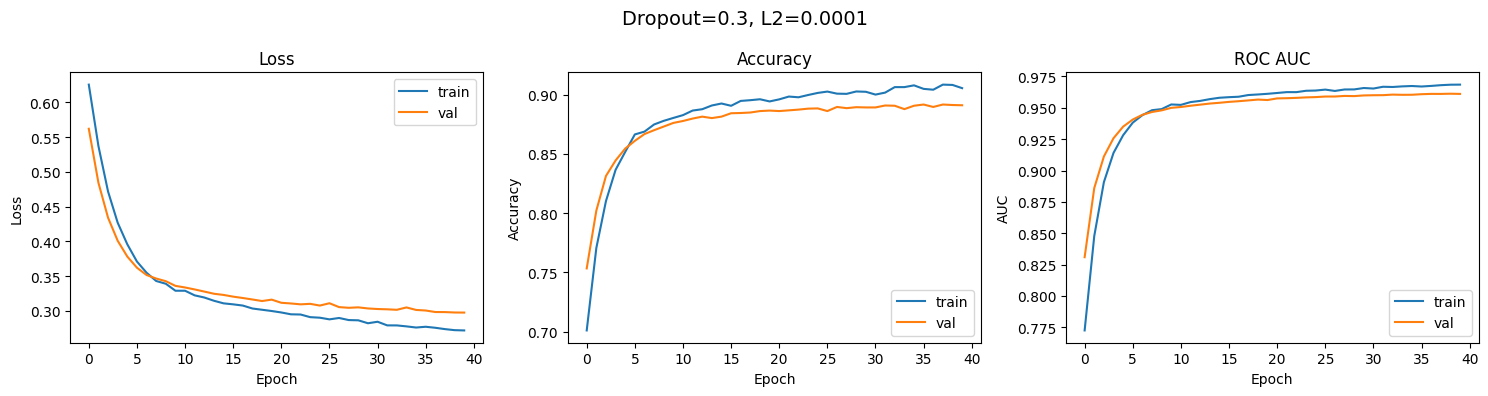

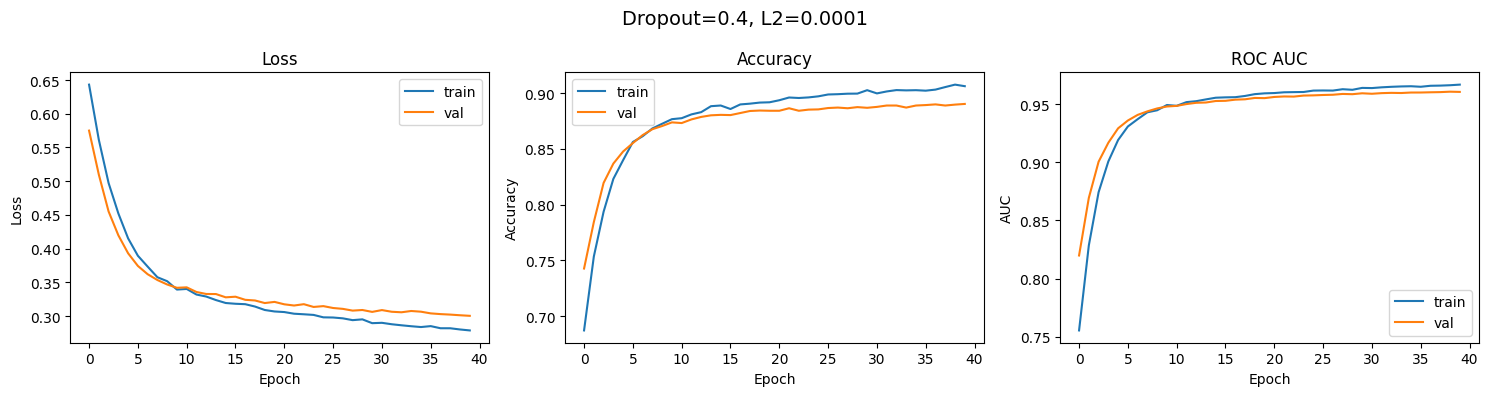

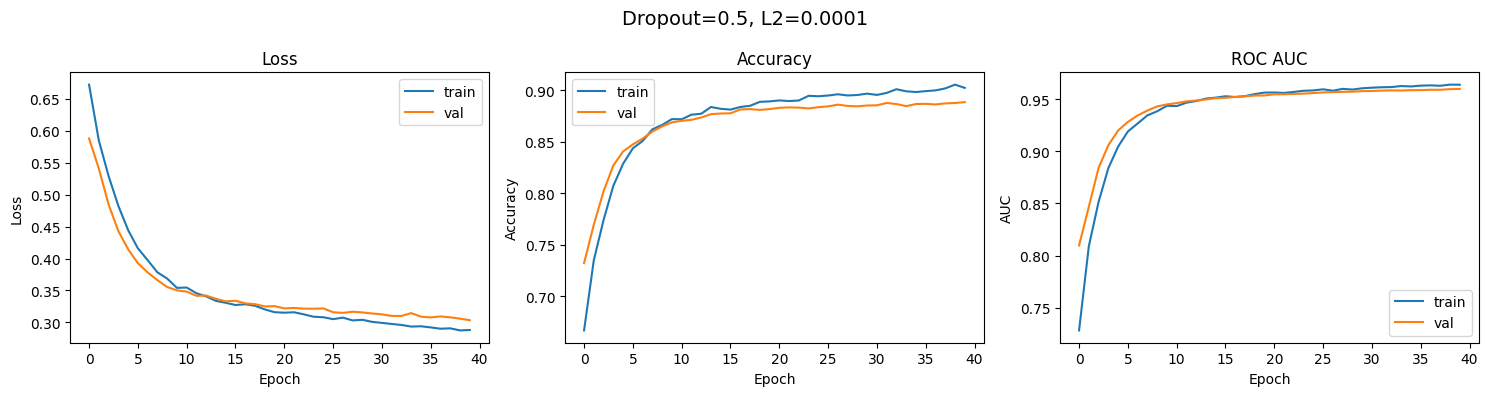

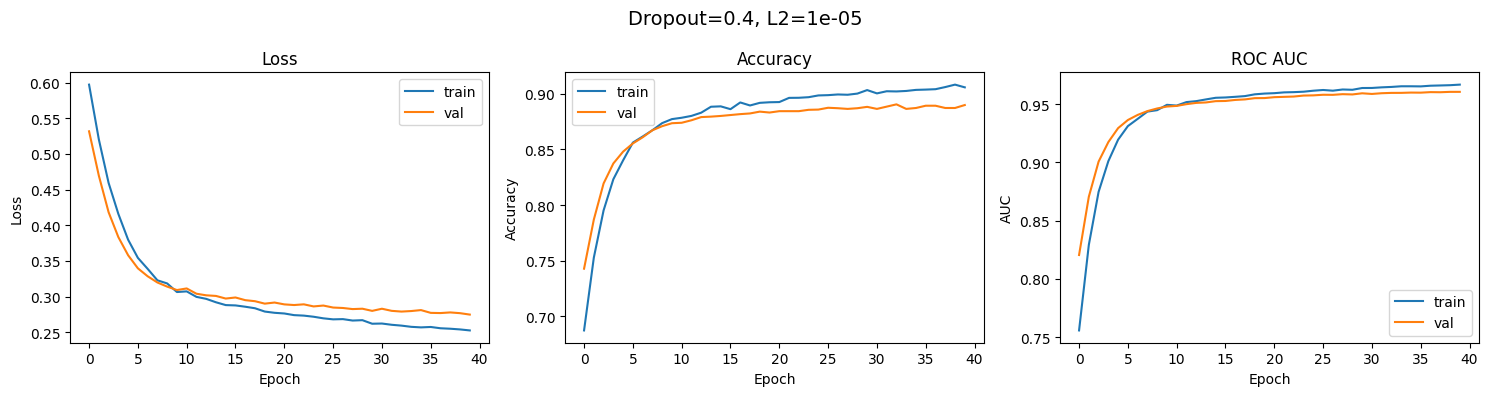

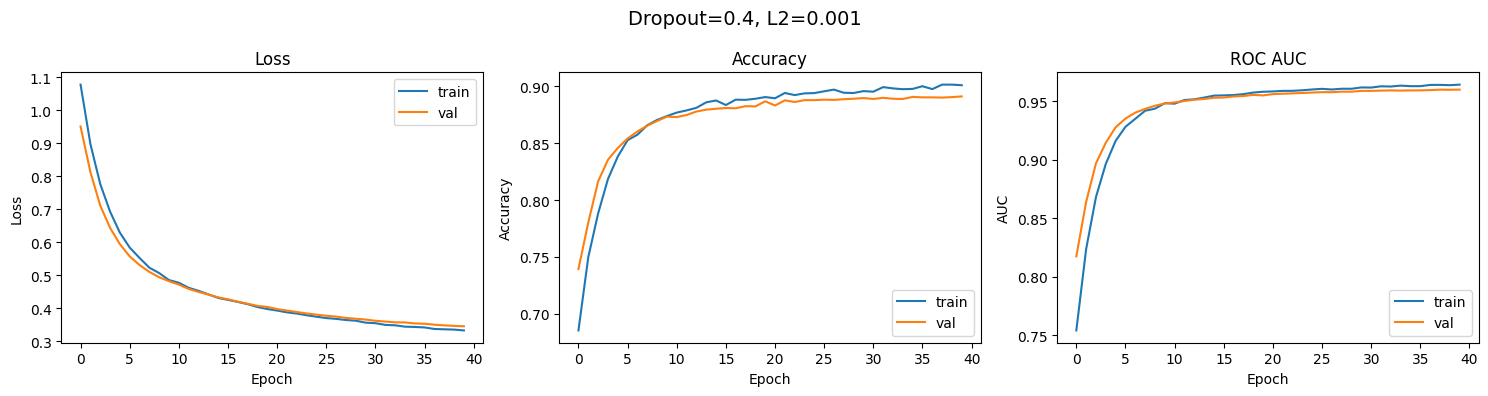

In [115]:
# === Plot curves (Step 2: Regularization Search) ===
for (dr, l2reg), hist in histories2_mlp.items():
    title = f"Dropout={dr}, L2={l2reg}"
    plot_history_dict(hist, title=title)

In [116]:
best_mlp_dropout = 0.4
best_mlp_12_reg = 1e-3

---Optimizer & LR Search---

In [117]:
search_space3_mlp = [
    ("adam",   5e-4),
    ("adam",   1e-4),   # baseline
    ("adam",   2e-4),
    ("adam",   3e-4),
    ("adamw",  2e-4),
    ("rmsprop",2e-4),
]

In [118]:
results3_mlp = []
histories3_mlp = {}

In [119]:
for opt, lr in search_space3_mlp:
    print(f"\n===== Testing optimizer={opt}, lr={lr} =====")
    set_seed(42)

    model = build_mlp(
        input_shape=(100, 768),
        hidden1=best_hiddent1,
        hidden2=best_hidden2,
        dropout=best_mlp_dropout,
        l2_reg=best_mlp_12_reg,
        learning_rate=lr,
        label_smoothing=0.01,
        clipnorm=1.0,
        optimizer=opt
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=64,
        verbose=0,
        callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True)]
    )

    val_auc = model.evaluate(X_val, y_val, verbose=0)[2]
    print(f"Validation AUROC: {val_auc:.4f}")

    results3_mlp.append((opt, lr, val_auc))
    histories3_mlp[(opt, lr)] = history.history


===== Testing optimizer=adam, lr=0.0005 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9576

===== Testing optimizer=adam, lr=0.0001 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9548

===== Testing optimizer=adam, lr=0.0002 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9580

===== Testing optimizer=adam, lr=0.0003 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9582

===== Testing optimizer=adamw, lr=0.0002 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9580

===== Testing optimizer=rmsprop, lr=0.0002 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9560


In [120]:
results3_mlp_sorted = sorted(results3_mlp, key=lambda x: x[2], reverse=True)
print("\n===== Summary of Optimizer & LR Search =====")
for opt, lr, auc in results3_mlp_sorted:
    print(f"optimizer={opt:7s}, lr={lr:.0e}  ->  val_roc_auc={auc:.4f}")


===== Summary of Optimizer & LR Search =====
optimizer=adam   , lr=3e-04  ->  val_roc_auc=0.9582
optimizer=adamw  , lr=2e-04  ->  val_roc_auc=0.9580
optimizer=adam   , lr=2e-04  ->  val_roc_auc=0.9580
optimizer=adam   , lr=5e-04  ->  val_roc_auc=0.9576
optimizer=rmsprop, lr=2e-04  ->  val_roc_auc=0.9560
optimizer=adam   , lr=1e-04  ->  val_roc_auc=0.9548


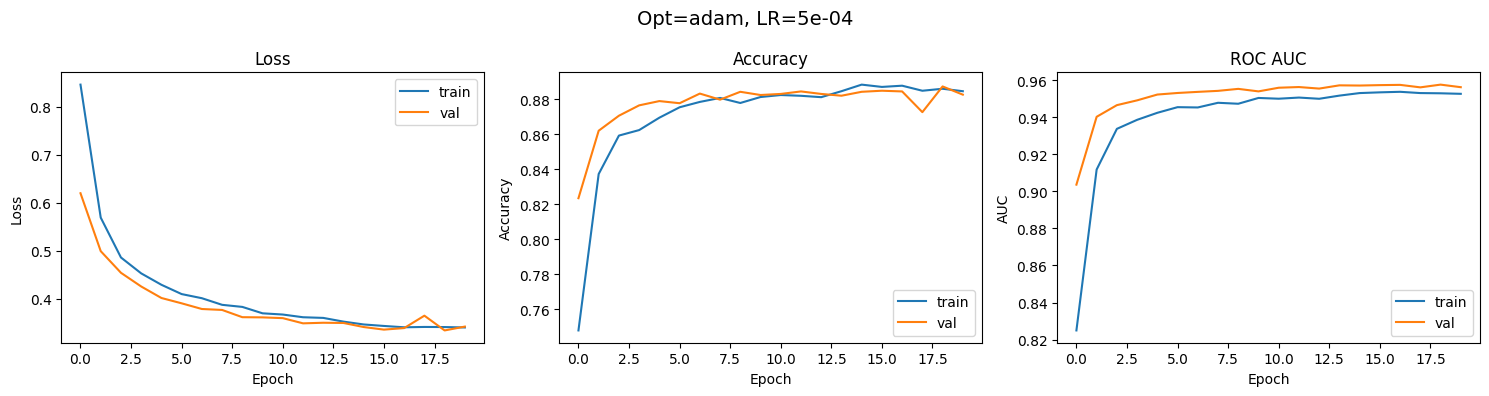

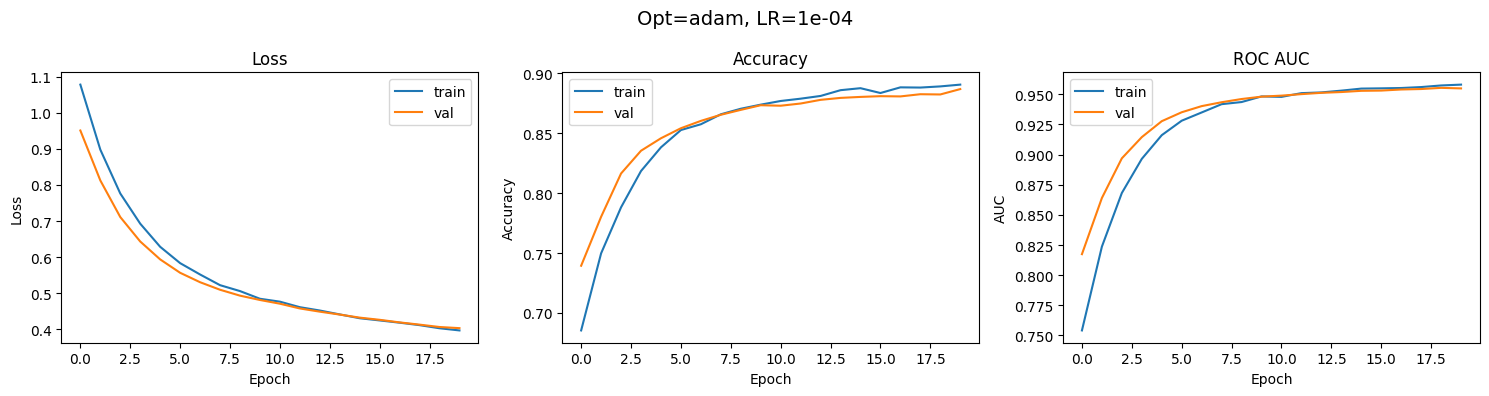

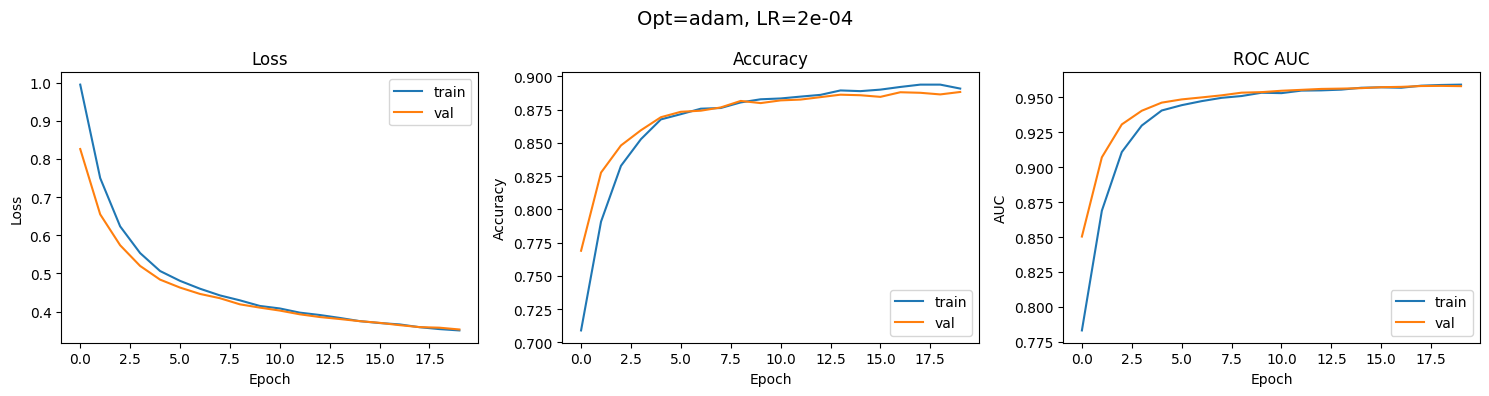

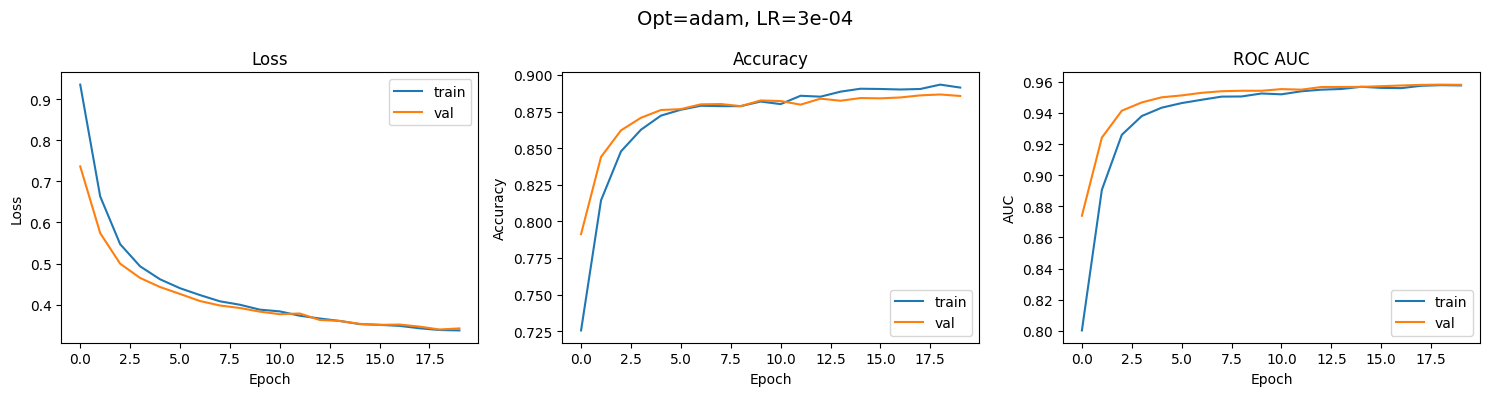

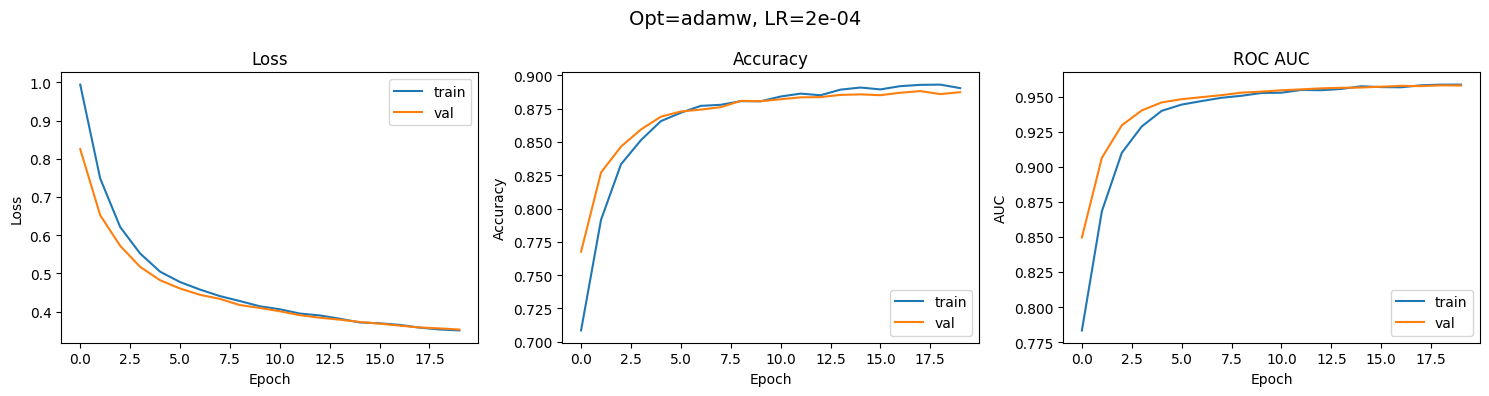

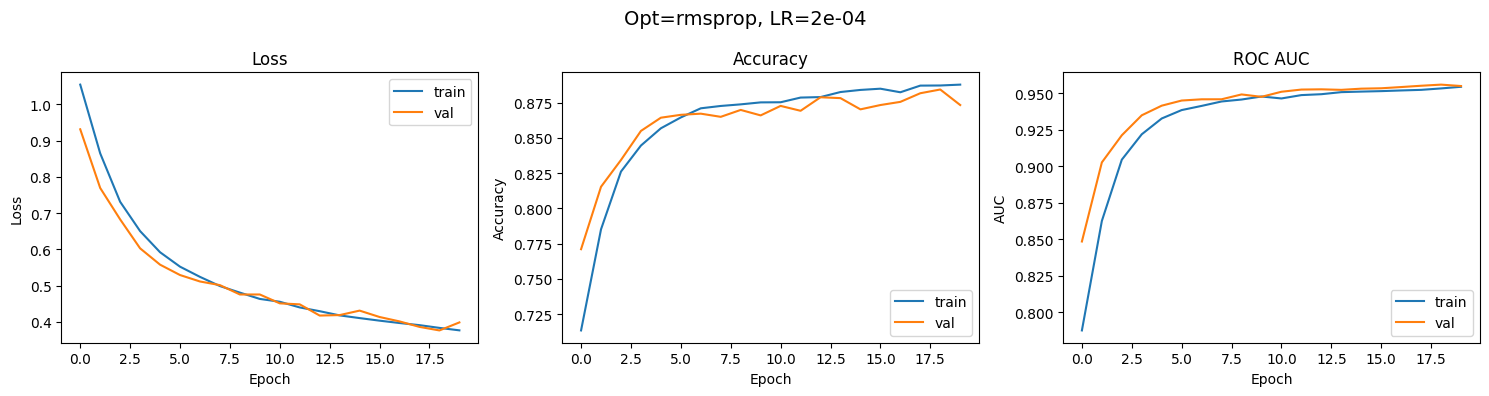

In [121]:
# === Plot curves (Step 3: Optimizer & LR Search for MLP) ===
for (opt, lr), hist in histories3_mlp.items():
    title = f"Opt={opt}, LR={lr:.0e}"
    plot_history_dict(hist, title=title)

In [122]:
best_mlp_opt = "adamw"
best_mlp_lr = 3e-4

---Test Batch Normalization-----

In [123]:
search_bn = [False, True]

results_bn = []
histories_bn = {}

In [124]:
for bn in search_bn:
    print(f"\n===== Testing BatchNorm={bn} =====")
    set_seed(42)

    model = build_mlp(
        input_shape=(100, 768),
        hidden1=best_hiddent1,
        hidden2=best_hidden2,
        dropout=best_mlp_dropout,
        l2_reg=best_mlp_12_reg,
        learning_rate=best_mlp_lr,
        clipnorm=1.0,
        use_batchnorm=bn,
        optimizer=best_mlp_opt
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=64,
        verbose=0,
        callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True
        )]
    )

    val_auc = model.evaluate(X_val, y_val, verbose=0)[2]
    print(f"Validation AUROC: {val_auc:.4f}")

    results_bn.append((bn, val_auc))
    histories_bn[bn] = history.history


===== Testing BatchNorm=False =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9586

===== Testing BatchNorm=True =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9627


In [125]:
# === Summary ===
print("\n===== Summary: BatchNorm Test =====")
for bn, auc in results_bn:
    print(f"BatchNorm={bn}  ->  val_roc_auc={auc:.4f}")


===== Summary: BatchNorm Test =====
BatchNorm=False  ->  val_roc_auc=0.9586
BatchNorm=True  ->  val_roc_auc=0.9627


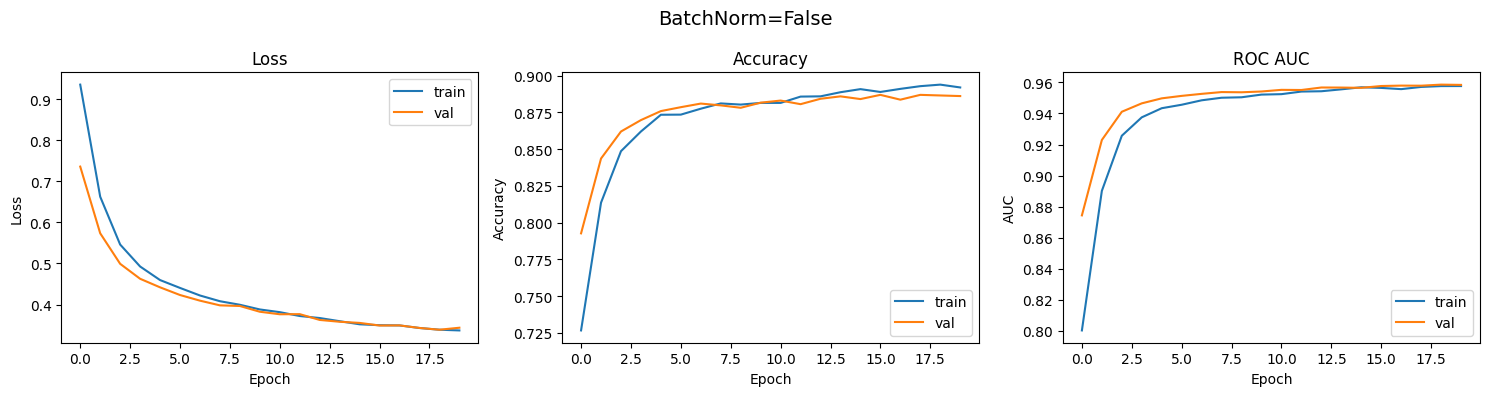

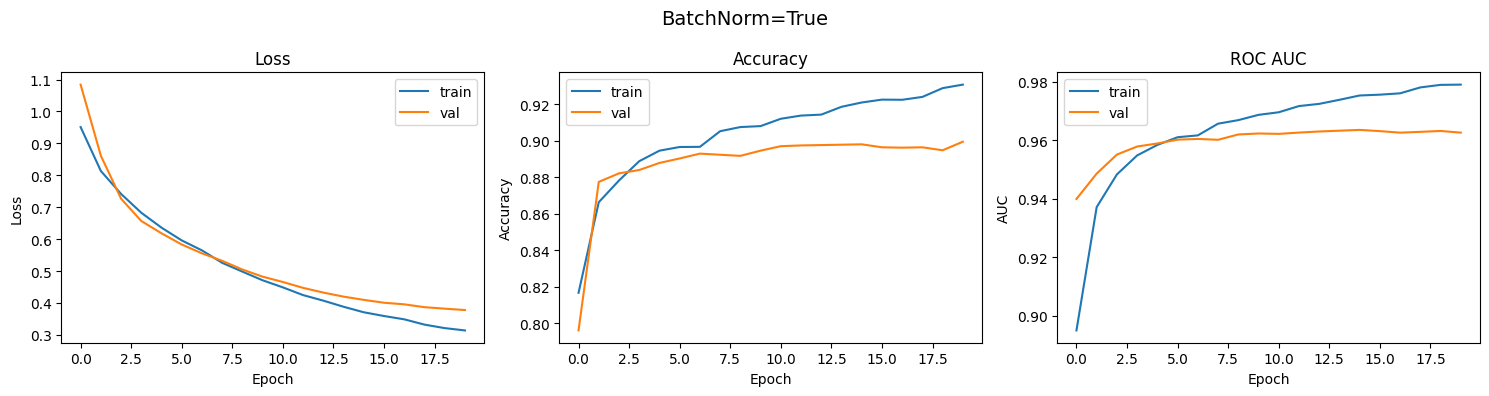

In [126]:
for bn, hist in histories_bn.items():
    title = f"BatchNorm={bn}"
    plot_history_dict(hist, title=title)

In [127]:
best_mlp_bn = False

---Step 4b: Activation Function Test---

In [128]:
# === Step 4b: Activation Function Test ===
search_act = ["relu", "gelu", "tanh"]

In [129]:
results_act = []
histories_act = {}

In [130]:
for act in search_act:
    print(f"\n===== Testing Activation={act} =====")
    set_seed(42)

    model = build_mlp(
        input_shape=(100, 768),
        hidden1=best_hiddent1,
        hidden2=best_hidden2,
        dropout=best_mlp_dropout,
        l2_reg=best_mlp_12_reg,
        learning_rate=best_mlp_lr,
        clipnorm=1.0,
        activation=act,
        use_batchnorm=best_mlp_bn,
        optimizer=best_mlp_opt
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=64,
        verbose=0,
        callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True
        )]
    )

    val_auc = model.evaluate(X_val, y_val, verbose=0)[2]
    print(f"Validation AUROC: {val_auc:.4f}")

    results_act.append((act, val_auc))
    histories_act[act] = history.history


===== Testing Activation=relu =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9586

===== Testing Activation=gelu =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9562

===== Testing Activation=tanh =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9584


In [131]:
# === Summary ===
print("\n===== Summary: Activation Function Test =====")
for act, auc in results_act:
    print(f"Activation={act:5s}  ->  val_roc_auc={auc:.4f}")


===== Summary: Activation Function Test =====
Activation=relu   ->  val_roc_auc=0.9586
Activation=gelu   ->  val_roc_auc=0.9562
Activation=tanh   ->  val_roc_auc=0.9584


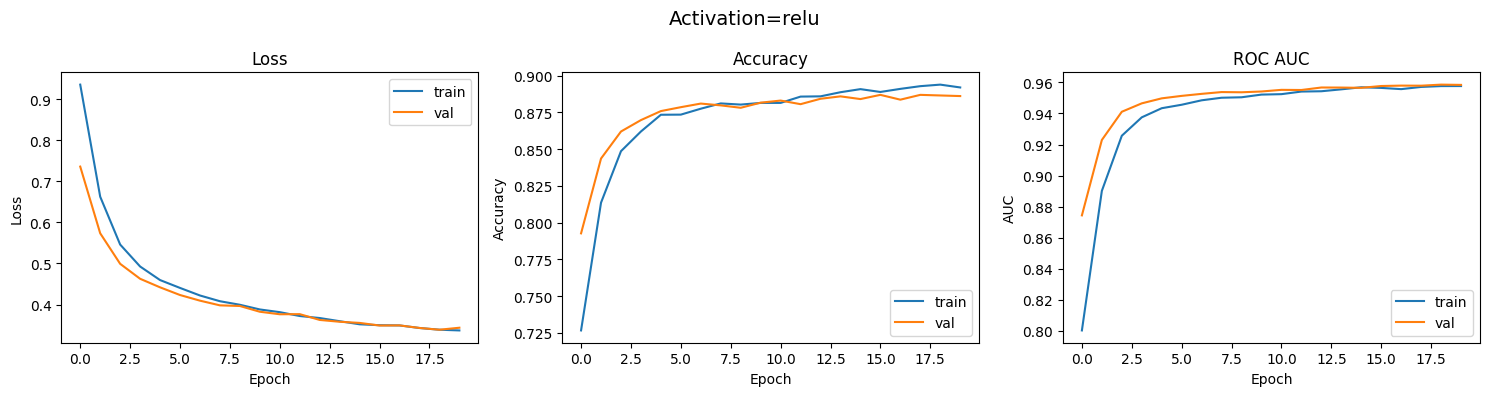

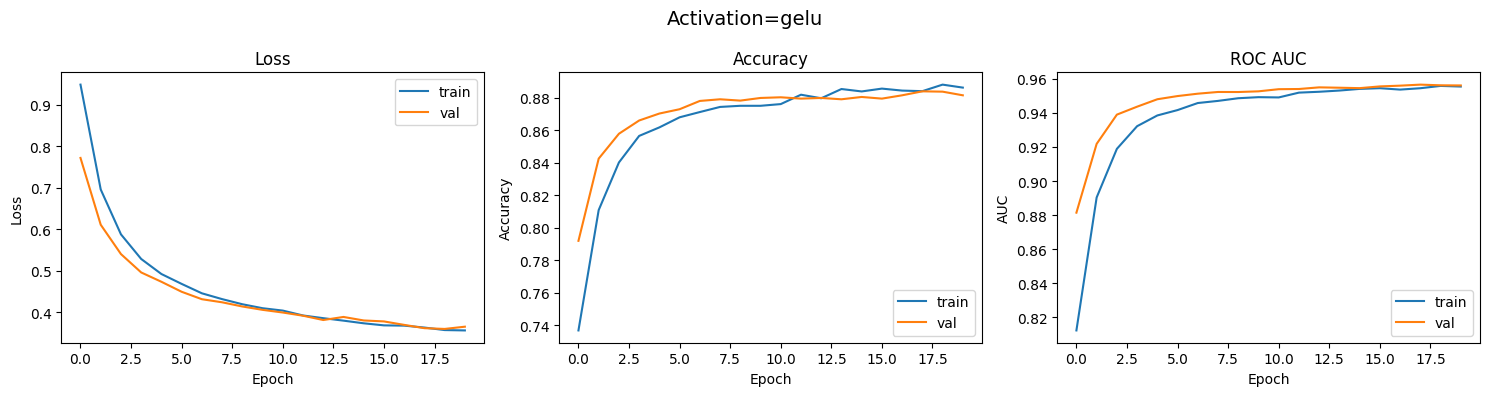

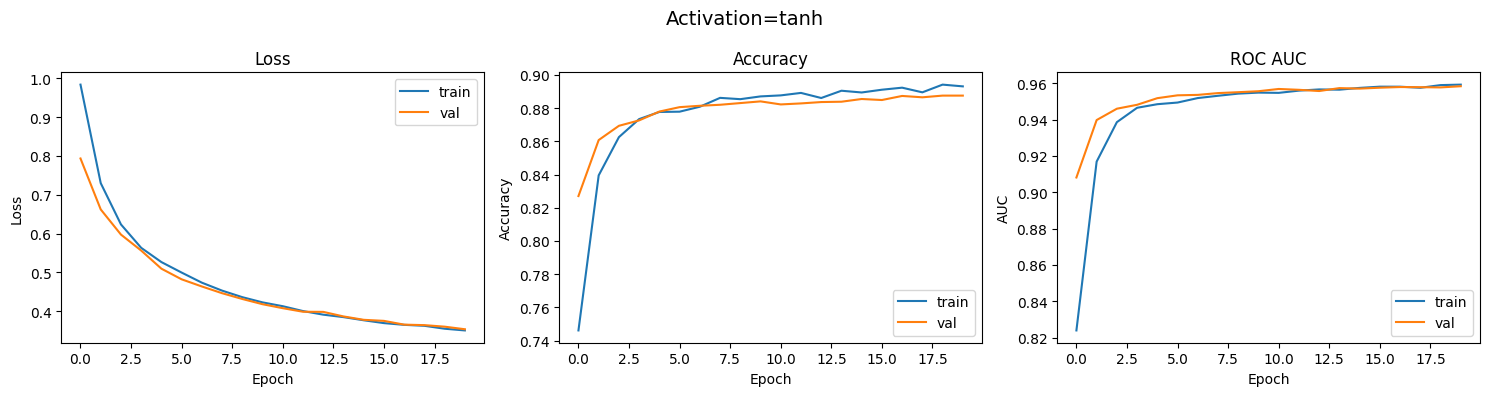

In [132]:
for act, hist in histories_act.items():
    title = f"Activation={act}"
    plot_history_dict(hist, title=title)

In [133]:
best_mlp_activation = "relu"

---Step 4c: Label Smoothing Test---

In [135]:
# === Step 4c: Label Smoothing Test ===
search_ls = [0.0, 0.01, 0.05, 0.1]

results_ls = []
histories_ls = {}

In [136]:
for ls in search_ls:
    print(f"\n===== Testing Label Smoothing={ls} =====")
    set_seed(42)

    model = build_mlp(
        input_shape=(100, 768),
        hidden1=best_hiddent1,
        hidden2=best_hidden2,
        dropout=best_mlp_dropout,
        l2_reg=best_mlp_12_reg,
        learning_rate=best_mlp_lr,
        label_smoothing=ls,
        clipnorm=1.0,
        activation=best_mlp_activation,
        use_batchnorm=best_mlp_bn,
        optimizer=best_mlp_opt
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=20,
        batch_size=64,
        verbose=0,
        callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True
        )]
    )

    val_auc = model.evaluate(X_val, y_val, verbose=0)[2]
    print(f"Validation AUROC: {val_auc:.4f}")

    results_ls.append((ls, val_auc))
    histories_ls[ls] = history.history


===== Testing Label Smoothing=0.0 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9586

===== Testing Label Smoothing=0.01 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9586

===== Testing Label Smoothing=0.05 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9587

===== Testing Label Smoothing=0.1 =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9588


In [137]:
print("\n===== Summary: Label Smoothing Test =====")
for ls, auc in results_ls:
    print(f"LabelSmoothing={ls:.2f}  ->  val_roc_auc={auc:.4f}")


===== Summary: Label Smoothing Test =====
LabelSmoothing=0.00  ->  val_roc_auc=0.9586
LabelSmoothing=0.01  ->  val_roc_auc=0.9586
LabelSmoothing=0.05  ->  val_roc_auc=0.9587
LabelSmoothing=0.10  ->  val_roc_auc=0.9588


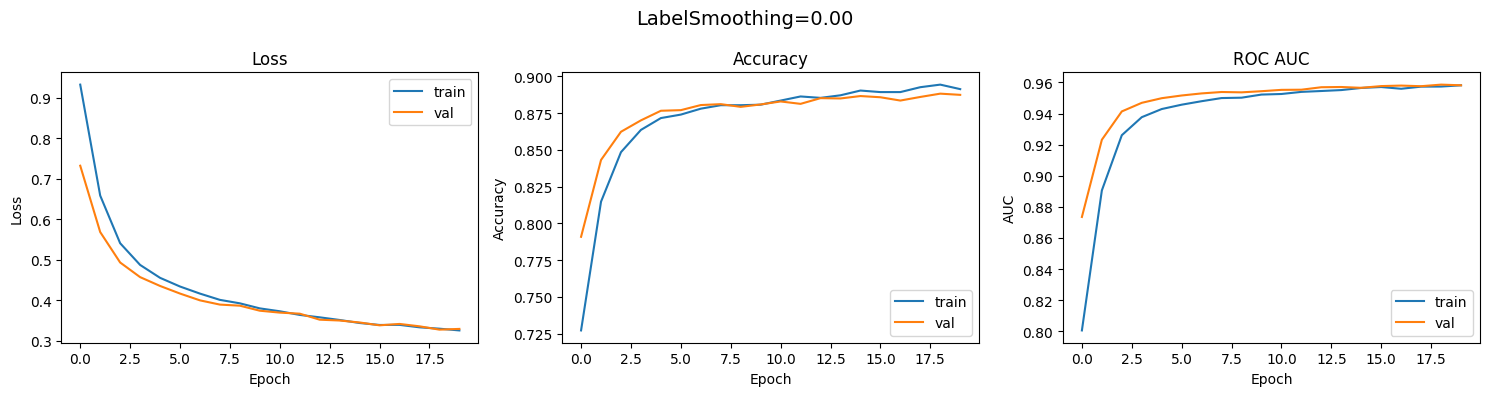

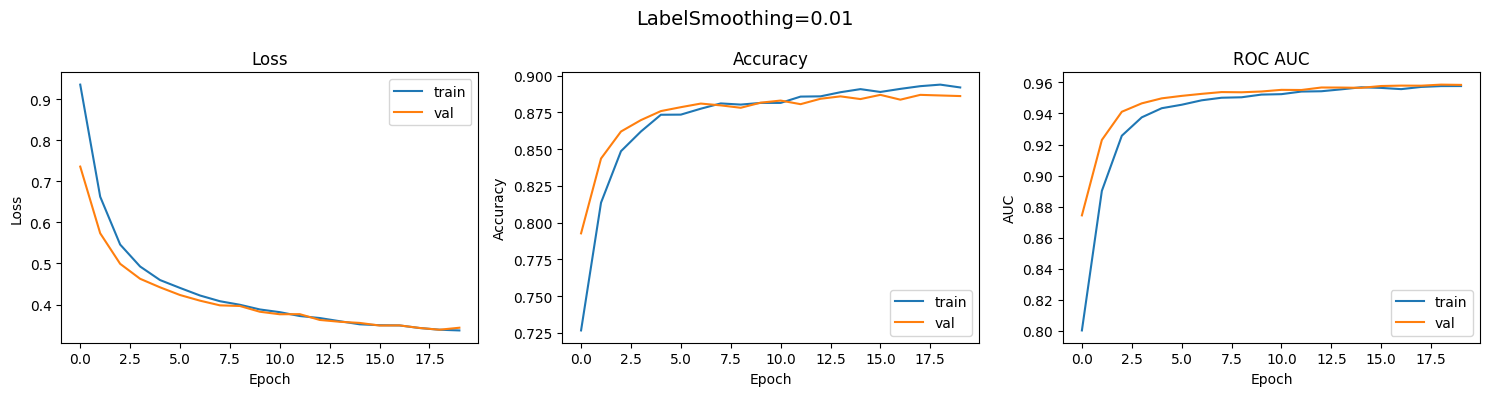

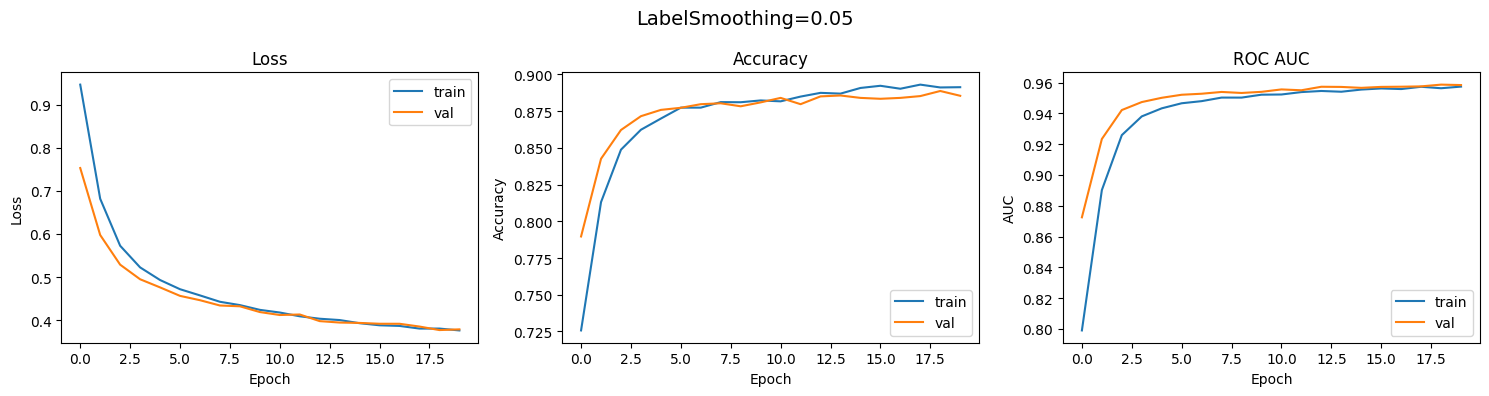

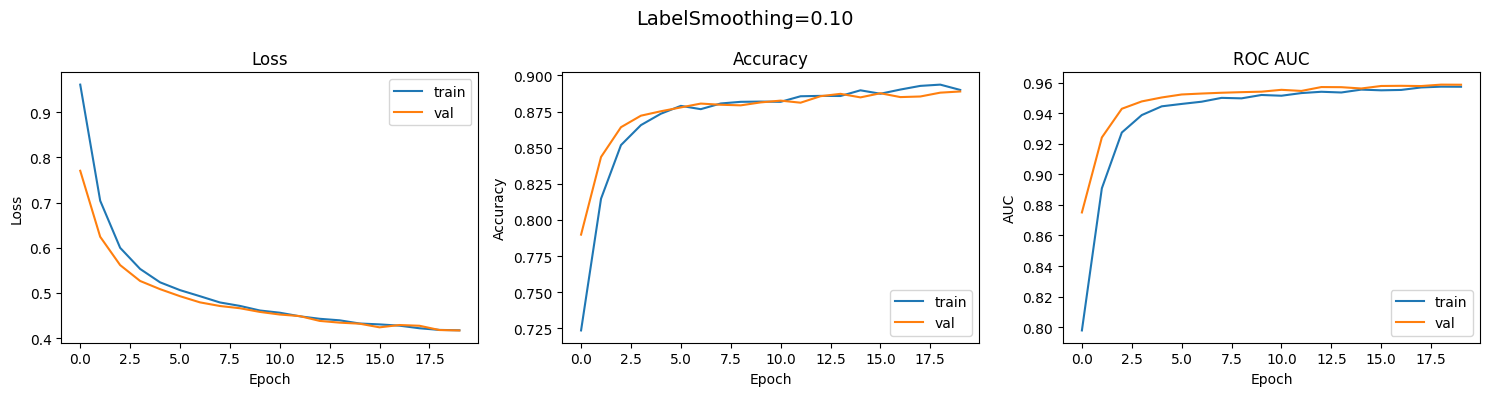

In [138]:
for ls, hist in histories_ls.items():
    title = f"LabelSmoothing={ls:.2f}"
    plot_history_dict(hist, title=title)

In [145]:
best_mlp_ls = 0.1

---Tyr Callbacks---

In [146]:
cb_es = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    )
]

cb_reduceLR = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6
    )
]

def cosine_scheduler(epoch, lr, max_lr=best_lr, min_lr=1e-6, T_max=20):
    """Simple cosine annealing schedule."""
    return min_lr + 0.5 * (max_lr - min_lr) * (1 + np.cos(np.pi * epoch / T_max))

cb_cosine = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    ),
    tf.keras.callbacks.LearningRateScheduler(
        lambda epoch, lr: cosine_scheduler(epoch, lr), verbose=0
    )
]

In [147]:
callback_sets = {
    "ES": cb_es,
    "ReduceLR": cb_reduceLR,
    "Cosine": cb_cosine
}

In [148]:
results_cb = {}
histories_cb = {}

In [149]:
for name, cb in callback_sets.items():
    print(f"\n===== Testing Callbacks={name} =====")
    set_seed(42)

    model = build_mlp(
        input_shape=(100, 768),
        hidden1=best_hiddent1,
        hidden2=best_hidden2,
        dropout=best_mlp_dropout,
        l2_reg=best_mlp_12_reg,
        learning_rate=best_mlp_lr,
        label_smoothing=best_mlp_ls,
        clipnorm=1.0,
        activation=best_mlp_activation,
        use_batchnorm=best_mlp_bn,
        optimizer=best_mlp_opt
    )

    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=40,
        batch_size=64,
        verbose=0,
        callbacks=cb
    )

    val_auc = model.evaluate(X_val, y_val, verbose=0)[2]
    results_cb[name] = val_auc
    histories_cb[name] = history.history
    print(f"Validation AUROC: {val_auc:.4f}")


===== Testing Callbacks=ES =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9597

===== Testing Callbacks=ReduceLR =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9614

===== Testing Callbacks=Cosine =====
[INFO] Seed set to 42, deterministic ops enabled
Validation AUROC: 0.9591


In [150]:
# === Summary ===
print("\n===== Summary: Callback Test =====")
for name, auc in results_cb.items():
    print(f"{name:8s} -> val_roc_auc={auc:.4f}")


===== Summary: Callback Test =====
ES       -> val_roc_auc=0.9597
ReduceLR -> val_roc_auc=0.9614
Cosine   -> val_roc_auc=0.9591


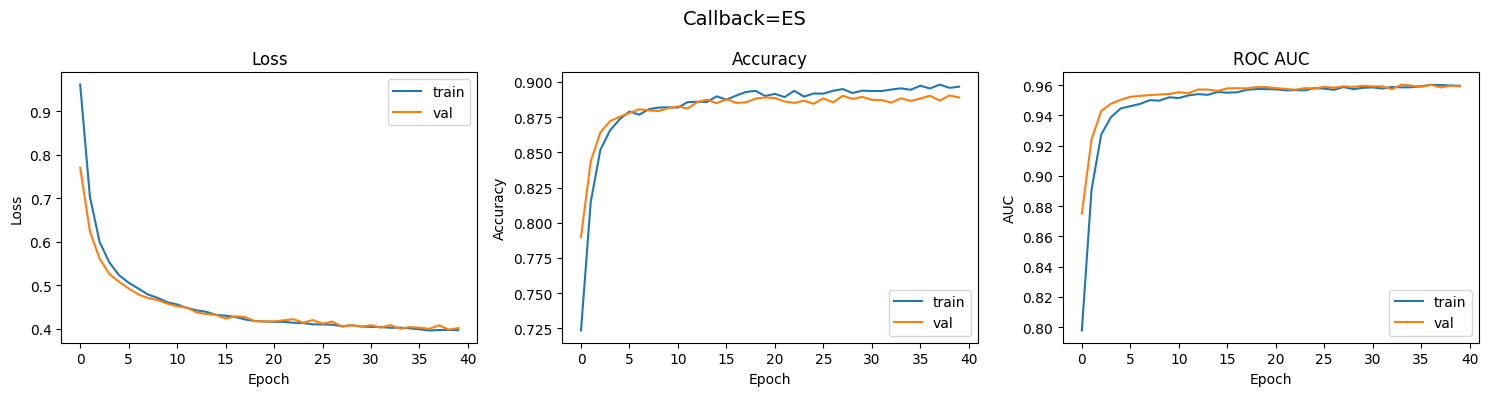

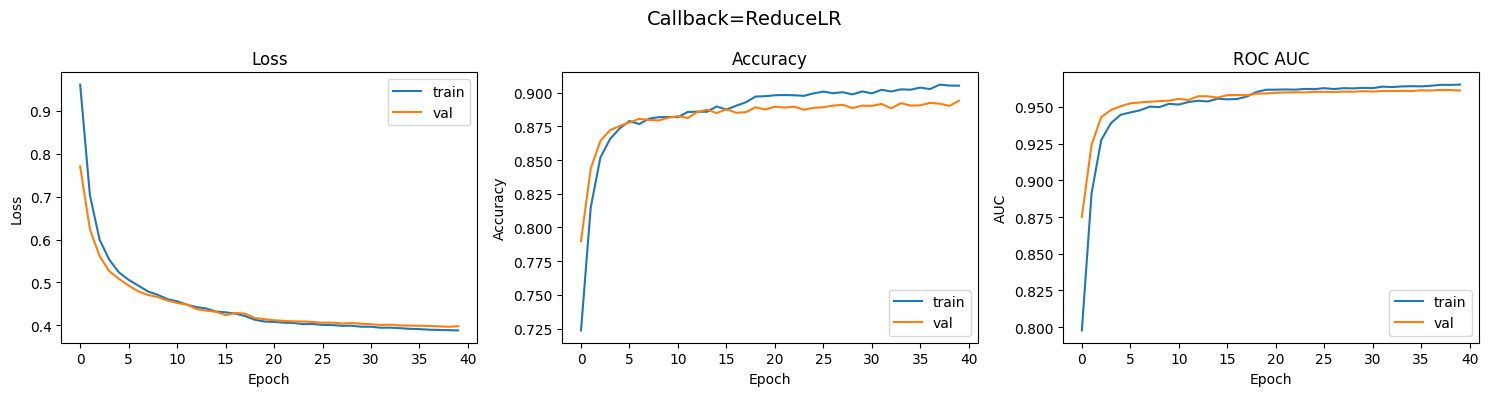

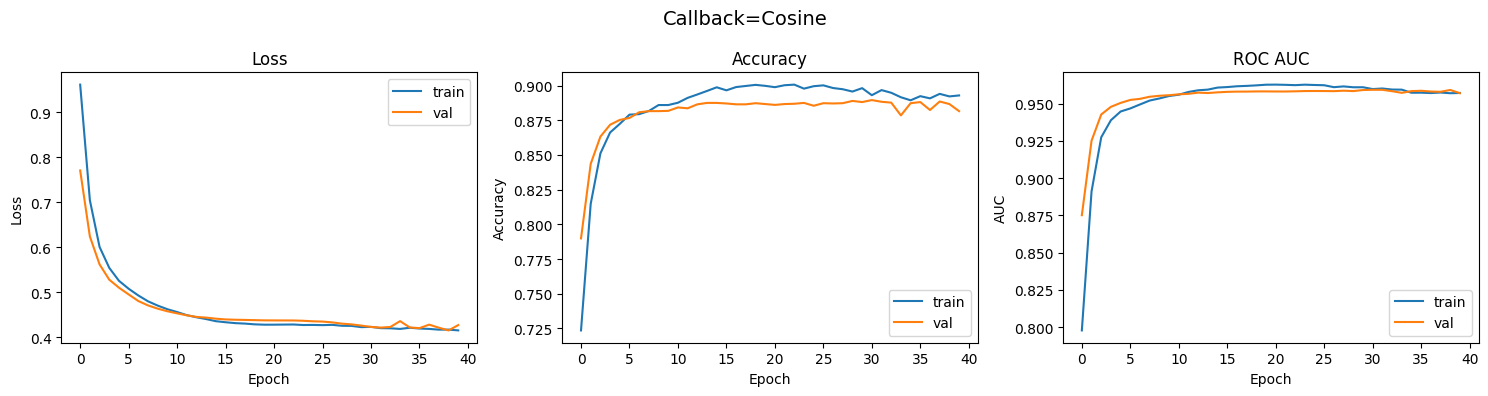

In [151]:
for name, hist in histories_cb.items():
    plot_history_dict(hist, title=f"Callback={name}")

In [152]:
best_mlp_es = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6
    )
]

---Form Final MLP Model----

In [153]:
def print_best_mlp_config():
    best_params = {
        "hidden1": best_hiddent1,
        "hidden2": best_hidden2,
        "dropout": best_mlp_dropout,
        "l2_reg": best_mlp_12_reg,
        "learning_rate": best_mlp_lr,
        "label_smoothing": best_mlp_ls,
        "activation": best_mlp_activation,
        "use_batchnorm": best_mlp_bn,
        "optimizer": best_mlp_opt,
    }

    print("\n===== Best MLP Config =====")
    for name, val in best_params.items():
        print(f"{name:15s}: {val}")

print_best_mlp_config()


===== Best MLP Config =====
hidden1        : 256
hidden2        : 128
dropout        : 0.4
l2_reg         : 0.001
learning_rate  : 0.0003
label_smoothing: 0.1
activation     : relu
use_batchnorm  : False
optimizer      : adamw


In [158]:
set_seed(42)

final_mlp = build_mlp(
    input_shape=(100, 768),
    hidden1=best_hiddent1,
    hidden2=best_hidden2,
    dropout=best_mlp_dropout,
    l2_reg=best_mlp_12_reg,
    learning_rate=best_mlp_lr,
    label_smoothing=best_mlp_ls,
    clipnorm=1.0,
    activation=best_mlp_activation,
    use_batchnorm=best_mlp_bn,
    optimizer=best_mlp_opt
)

final_mlp.summary()

[INFO] Seed set to 42, deterministic ops enabled


Model: "functional_75"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_75      │ (None, 100, 768)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_150 (Lambda) │ (None, 100)       │          0 │ input_layer_75[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_151 (Lambda) │ (None, 768)       │          0 │ input_layer_75[0… │
│                     │                   │            │ lambda_150[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_186 (Dense)   │ (None, 256)       │    196,864 │ lambda_151[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_149         │ (None, 256)       │          0 │ dense_186[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_187 (Dense)   │ (None, 128)       │     32,896 │ dropout_149[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_150         │ (None, 128)       │          0 │ dense_187[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_188 (Dense)   │ (None, 1)         │        129 │ dropout_150[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 229,889 (898.00 KB)

 Trainable params: 229,889 (898.00 KB)

 Non-trainable params: 0 (0.00 B)

In [159]:
history_mlp = final_mlp.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    verbose=1,
    callbacks=best_mlp_es
)

Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.6769 - loss: 1.0847 - roc_auc: 0.7389 - val_accuracy: 0.7899 - val_loss: 0.7704 - val_roc_auc: 0.8751 - learning_rate: 3.0000e-04
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8038 - loss: 0.7399 - roc_auc: 0.8790 - val_accuracy: 0.8436 - val_loss: 0.6243 - val_roc_auc: 0.9242 - learning_rate: 3.0000e-04
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8490 - loss: 0.6144 - roc_auc: 0.9239 - val_accuracy: 0.8642 - val_loss: 0.5616 - val_roc_auc: 0.9430 - learning_rate: 3.0000e-04
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8620 - loss: 0.5621 - roc_auc: 0.9370 - val_accuracy: 0.8722 - val_loss: 0.5265 - val_roc_auc: 0.9478 - learning_rate: 3.0000e-04
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.8702 - loss: 0.5309 - roc_auc: 0.9428 - val_accuracy: 0.8752 - val_loss: 0.5084 - val_roc_auc: 0.9504 - learning_rate: 3.0000e-04
Epoch 6/50
179/

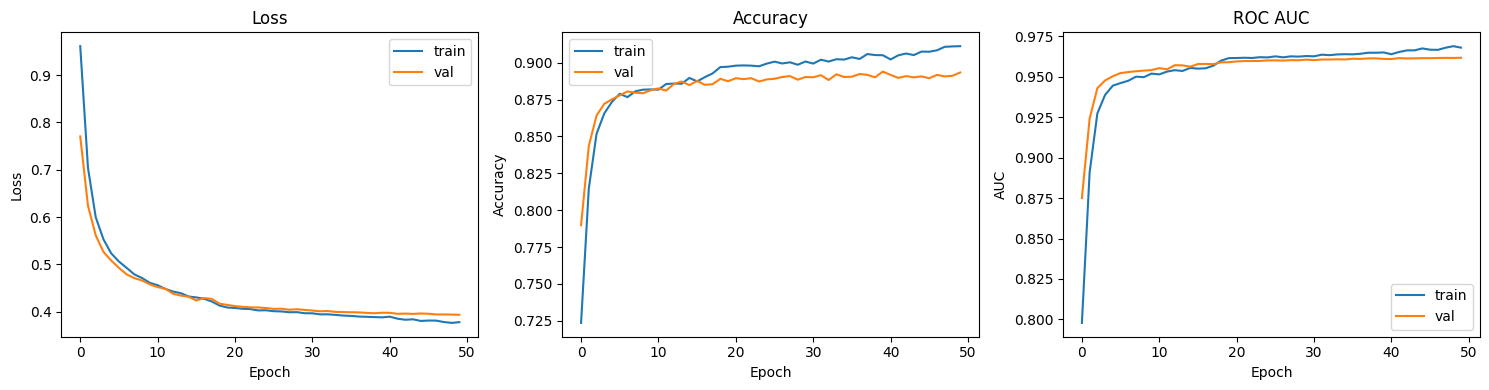

In [160]:
plot_history(history_mlp)

In [161]:
evaluate_model(model=final_mlp, X=X_val_external, y=y_val_external, ids=val_ids, agg="mean")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Sample-level AUROC: 0.7923
Classification Report (sample-level):
              precision    recall  f1-score   support

           0      0.707     0.855     0.774       124
           1      0.743     0.542     0.627        96

    accuracy                          0.718       220
   macro avg      0.725     0.698     0.700       220
weighted avg      0.722     0.718     0.709       220

Doc-level AUROC (mean): 0.99


In [162]:
y_test_prob_mlp = final_mlp.predict(X_test).ravel()
df_probs_mlp = pd.DataFrame({'id': test_ids, 'prob': y_test_prob_mlp})
final_probs_mlp = df_probs_mlp.groupby('id')['prob'].mean().reset_index()
print(final_probs_mlp.head())

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
   id      prob
0  15  0.110243
1  16  0.201591
2  17  0.087418
3  18  0.373871
4  19  0.214925


In [163]:
out_dir = "/content/drive/MyDrive/my_exports"  # save to my google drive
os.makedirs(out_dir, exist_ok=True)

save_path = os.path.join(out_dir, "final_probs_mlp.csv")
final_probs_mlp.to_csv(save_path, index=False, encoding="utf-8")
print("Saved to:", save_path)

Saved to: /content/drive/MyDrive/my_exports/final_probs_mlp.csv


In [164]:
save_model(final_mlp, base_name="final_mlp")

✅ Model saved:
  - /content/drive/MyDrive/my_exports/final_mlp_20250818_115935.keras
  - /content/drive/MyDrive/my_exports/final_mlp_20250818_115935.h5
